# Analysis notebook to analyze behavior and reactivations

In [1]:
# %matplotlib notebook
%matplotlib inline

# %connect_info

import flow.misc
text = """
Jupyter connect hash:
{word}

To connect to current notebook:
    $> jupyter console --existing {filename}
    
"""
print(text.format(word=flow.misc.notebook_word(), filename=flow.misc.notebook_file(flow.misc.notebook_word())))
print("Last run: {}".format(flow.misc.timestamp()))


Jupyter connect hash:
replace

To connect to current notebook:
    $> jupyter console --existing kernel-fc6747b5-2c89-4c1c-8ddc-e3a1cc60cae5.json
    

Last run: 2018-10-05-11h39m57s


/usr/local/lib/python2.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.23) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import jzap
import replay

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scipy.stats
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.anova import anova_lm
import patsy
import statsmodels.api as sm

from pdb import set_trace

import warnings
warnings.filterwarnings('ignore')

# path = '/lab/data/behavior_replay_180309.txt'
path = '/lab/data/behavior_replay_180518.txt'

data = jzap.misc.load_table(path)
print(data.columns)
print(data.head())

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Index([u'mouse', u'date', u'day_sum_eqdist_0_1_plus',
       u'day_frac_eqdist_0_1_plus', u'day_sum_eqdist_0_1_minus',
       u'day_frac_eqdist_0_1_minus', u'dprime', u'hmm_dprime',
       u'hmm_dprime_noneutral', u'hmm_dprime_run2', u'hmm_dprime_run3',
       u'hmm_dprime_run4', u'hmm_engagement', u'training_licks',
       u'lick_latency', u'running', u'replay_freq_0_1_plus',
       u'replay_freq_0_1_neutral', u'replay_freq_0_1_minus', u'n_stimuli_plus',
       u'n_stimuli_neutral', u'n_stimuli_minus', u'n_ensure', u'ncorrect_plus',
       u'ncorrect_minus', u'ncorrect_neutral', u'nfalse_plus', u'nfalse_minus',
       u'nfalse_neutral', u'hmm_ncorrect_plus', u'hmm_ncorrect_minus',
       u'hmm_ncorrect_neutral', u'hmm_nfalse_plus', u'hmm_nfalse_minus',
       u'hmm_nfalse_neutral', u'hmm_nfalse_all', u'hmm_ncorrect_all',
       u'fraction_visually_driven_50_plus',
       u'fraction_visually_driven_50_minus',
       u'fraction_visually_driven_50_neutral',
       u'fraction_visually_dri

In [3]:
pre_data = data[data['phase'].str.contains('A_pre')]
post_data = data[data['phase'].str.contains('B_post')]

mean_engage = data.hmm_engagement.mean()
mean_hmm_dprime = data.hmm_dprime.mean()
data = data.assign(
    engage_cat=data.hmm_engagement < mean_engage,
    hmm_dprime_cat=data.hmm_dprime < mean_hmm_dprime)
data.engage_cat = data.engage_cat.apply(
    lambda cat: 'low engagement' if cat else 'high engagement')
data.hmm_dprime_cat = data.hmm_dprime_cat.apply(
    lambda cat: 'low hmm dprime' if cat else 'high hmm dprime')

order = ['plus', 'minus', 'neutral']

## Split data by phase and plot behavior and reactivations over time

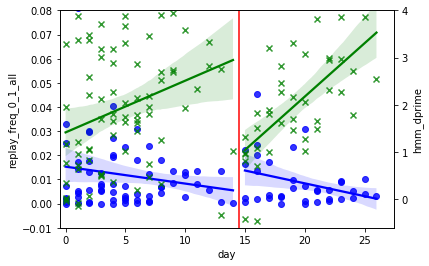

In [4]:
_, ax1 = plt.subplots()
sns.regplot(
    ax=ax1, y='replay_freq_0_1_all', x='day', data=pre_data, color='b',
    truncate=True)
sns.regplot(
    ax=ax1, y='replay_freq_0_1_all', x='day', data=post_data, color='b',
    truncate=True)
ax1.axvline(x=14.5, color='r', ls='-')
ax2 = ax1.twinx()
sns.regplot(
    ax=ax2, x='day', y='hmm_dprime', data=pre_data, color='g', marker='x',
    truncate=True)
sns.regplot(
    ax=ax2, x='day', y='hmm_dprime', data=post_data, color='g', marker='x',
    truncate=True)
ax1.set_xlim(-0.5, 27.5)
ax1.set_ylim(-0.01, 0.08)
ax2.set_ylim(-0.6, 4);

### Good example mouse: OA34

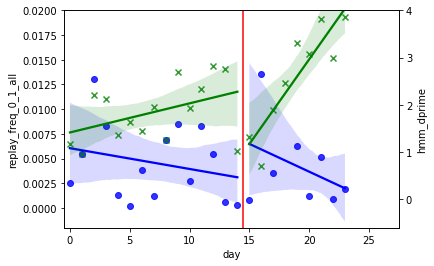

In [5]:
pre_mouse = pre_data[pre_data.mouse.str.contains('OA34')]
post_mouse = post_data[post_data.mouse.str.contains('OA34')]

_, ax1 = plt.subplots()
sns.regplot(
    ax=ax1, y='replay_freq_0_1_all', x='day', data=pre_mouse, color='b',
    truncate=True)
sns.regplot(
    ax=ax1, y='replay_freq_0_1_all', x='day', data=post_mouse, color='b',
    truncate=True)
ax1.axvline(x=14.5, color='r', ls='-')
ax2 = ax1.twinx()
sns.regplot(
    ax=ax2, x='day', y='hmm_dprime', data=pre_mouse, color='g', marker='x',
    truncate=True)
sns.regplot(
    ax=ax2, x='day', y='hmm_dprime', data=post_mouse, color='g', marker='x',
    truncate=True)
ax1.set_xlim(-0.5, 27.5)
ax1.set_ylim(-0.002, 0.02)
ax2.set_ylim(-0.6, 4);

## Overall behavior and reactivation correlation

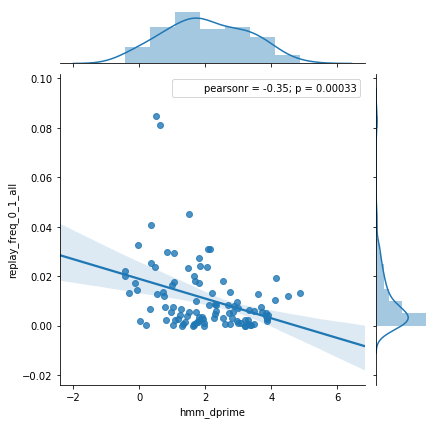

In [6]:
sns.jointplot(
    x='hmm_dprime', y='replay_freq_0_1_all', data=data, kind='reg') 

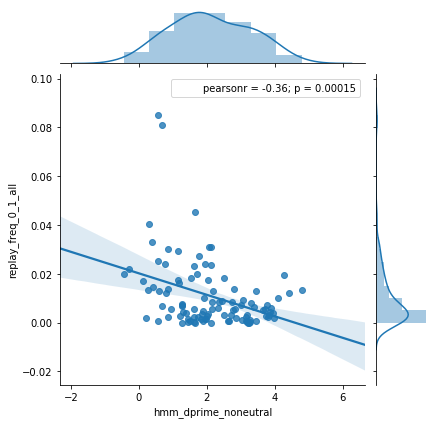

In [7]:
sns.jointplot(
    x='hmm_dprime_noneutral', y='replay_freq_0_1_all', data=data, kind='reg') 

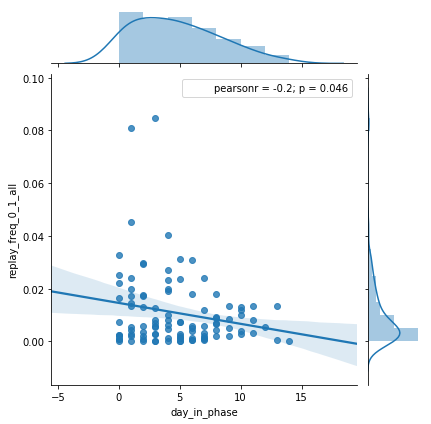

In [8]:
sns.jointplot(
    x='day_in_phase', y='replay_freq_0_1_all', data=data, kind='reg') 

## What is the interaction between reactivation, same day performance, and improvement
### Results
- consistently low reactivation when low performance and worse than yesterday
- higher reactivation when doing poorly but getting better

 rectangle highlights the low-reactivation, low-performance sessions, which all are decreasing performance sessions

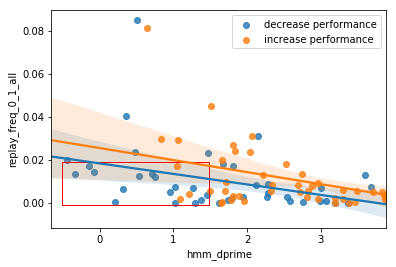

In [9]:
fig, ax = plt.subplots()
sns.regplot(
    ax=ax, y='replay_freq_0_1_all', x='hmm_dprime',
    data=data[data['d_hmm_dprime_prev'] < 0], label='decrease performance')
sns.regplot(
    ax=ax, y='replay_freq_0_1_all', x='hmm_dprime',
    data=data[data['d_hmm_dprime_prev'] > 0], label='increase performance')
rect = plt.Rectangle((-0.51, -0.001), 2.0, 0.02, fill=False, color='r')
ax.add_patch(rect)
ax.legend()

- rectangle highlights the low-performance, but improving sessions
- cyan circles are the 15 highest reactivation rate days

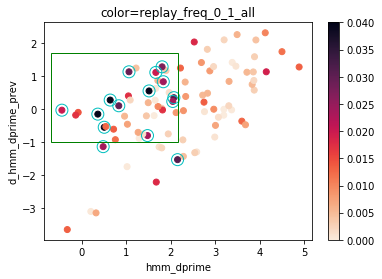

In [10]:
x = 'hmm_dprime'
y = 'd_hmm_dprime_prev'
hue = 'replay_freq_0_1_all'
# cmap = sns.cubehelix_palette(light=0.85, dark=0.15, as_cmap=True)
cmap = sns.cm.rocket_r

fig, ax = plt.subplots()
data_no_nan = data[[x, y, hue]]
data_no_nan.dropna(inplace=True)
x_data = np.array(data_no_nan[x])
y_data = np.array(data_no_nan[y])
hue_data = np.array(data_no_nan[hue])

plt.scatter(x_data, y_data, c=hue_data, cmap=cmap, vmax=0.04, s=36)
plt.colorbar(ax=ax)
plt.xlabel(x)
plt.ylabel(y)
plt.title('color={}'.format(hue))

top = hue_data.argsort()[-15:]
plt.scatter(x_data[top], y_data[top], edgecolor='c', marker='o', s=12**2, facecolor='none')

rect = plt.Rectangle((-0.7, -1), 2.85, 2.7, fill=False, color='g')
ax.add_patch(rect);

## Role of attention/engagement in reactivation rate

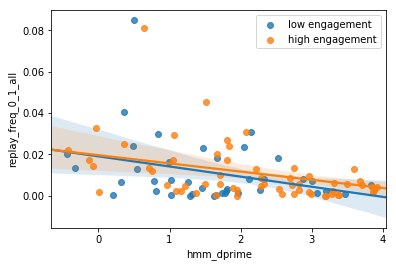

In [11]:
fig, ax = plt.subplots()
mean_engage = data['hmm_engagement'].mean()
sns.regplot( 
    ax=ax, y='replay_freq_0_1_all', x='hmm_dprime',
    data=data[data['hmm_engagement'] < mean_engage], label='low engagement')
g=sns.regplot(
    ax=ax, y='replay_freq_0_1_all', x='hmm_dprime',
    data=data[data['hmm_engagement'] > mean_engage], label='high engagement')
ax.legend()

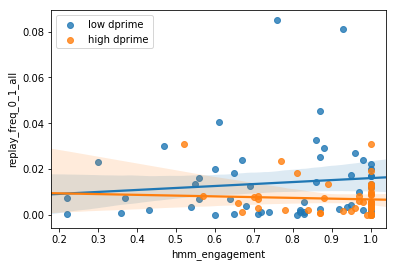

In [12]:
fig, ax = plt.subplots()
mean_dprime = data['hmm_dprime'].mean()
sns.regplot( 
    ax=ax, y='replay_freq_0_1_all', x='hmm_engagement',
    data=data[data['hmm_dprime'] < mean_dprime], label='low dprime')
g=sns.regplot(
    ax=ax, y='replay_freq_0_1_all', x='hmm_engagement',
    data=data[data['hmm_dprime'] > mean_dprime], label='high dprime')
ax.legend()

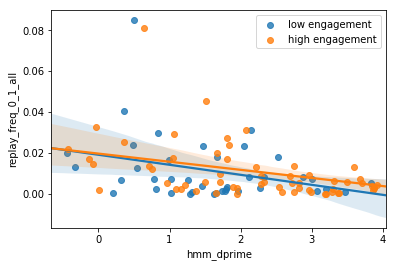

In [13]:
fig, ax = plt.subplots()
mean_engage = data['hmm_engagement'].mean()
sns.regplot( 
    ax=ax, y='replay_freq_0_1_all', x='hmm_dprime',
    data=data[data['hmm_engagement'] < mean_engage], label='low engagement')
g=sns.regplot(
    ax=ax, y='replay_freq_0_1_all', x='hmm_dprime',
    data=data[data['hmm_engagement'] > mean_engage], label='high engagement')
ax.legend()

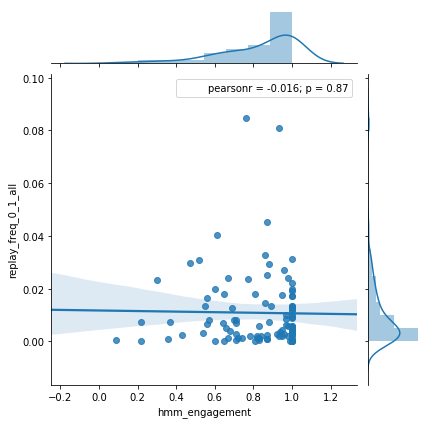

In [14]:
sns.jointplot(
    x='hmm_engagement', y='replay_freq_0_1_all', data=data, kind='reg') 

# Delta dprime vs. behavior
- All data delta with prev/next day and plus reactivations
### Results
- Opposite trend of positive and negative reactivations

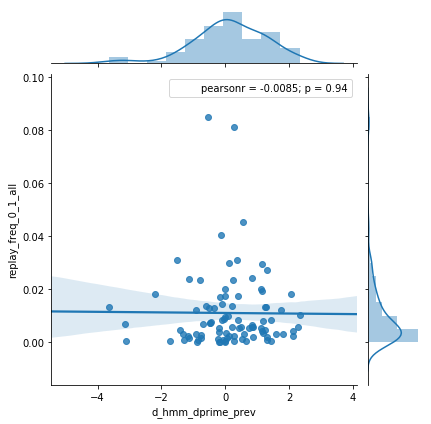

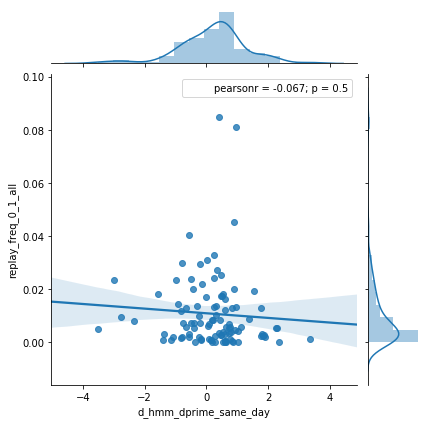

In [15]:
sns.jointplot(
    x='d_hmm_dprime_prev', y='replay_freq_0_1_all', data=data, kind='reg',
    truncate=False)
sns.jointplot(
    x='d_hmm_dprime_same_day', y='replay_freq_0_1_all', data=data, kind='reg',
    truncate=False)

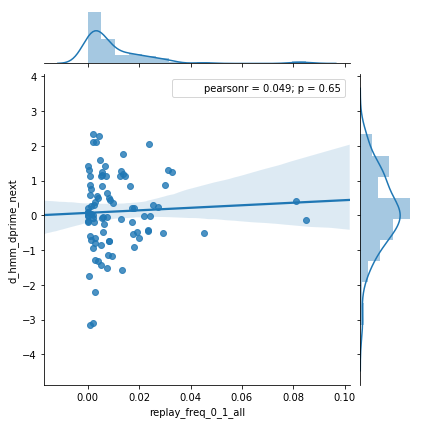

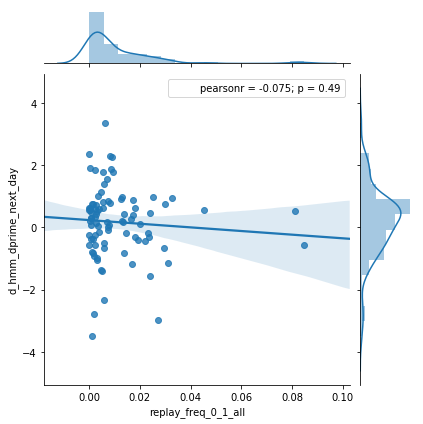

In [16]:
sns.jointplot(
    y='d_hmm_dprime_next', x='replay_freq_0_1_all', data=data, kind='reg',
    truncate=False)
sns.jointplot(
    y='d_hmm_dprime_next_day', x='replay_freq_0_1_all', data=data, kind='reg',
    truncate=False)

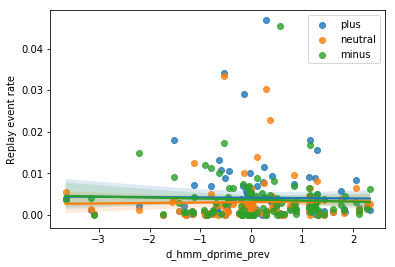

In [17]:
_, ax = plt.subplots()
sns.regplot(
    x='d_hmm_dprime_prev', y='replay_freq_0_1_plus', data=data,
    truncate=True, ax=ax, label='plus')
sns.regplot(
    x='d_hmm_dprime_prev', y='replay_freq_0_1_neutral', data=data,
    truncate=True, ax=ax, label='neutral')
sns.regplot(
    x='d_hmm_dprime_prev', y='replay_freq_0_1_minus', data=data,
    truncate=True, ax=ax, label='minus')
ax.set_ylabel('Replay event rate')
ax.legend()

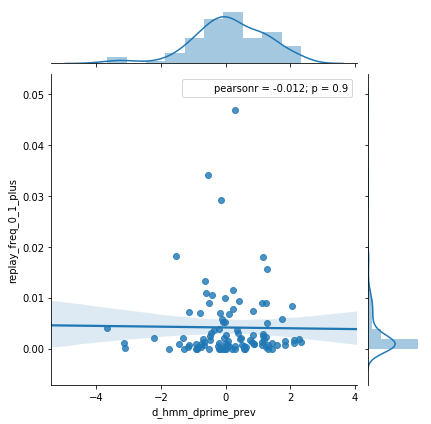

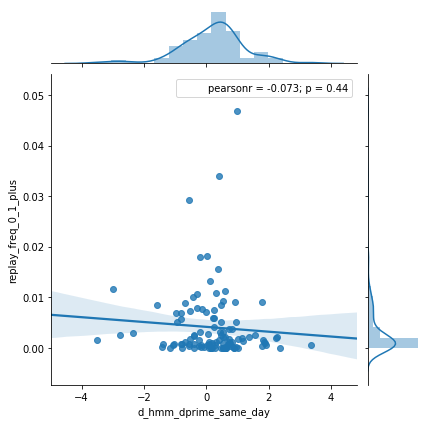

In [18]:
sns.jointplot(
    x='d_hmm_dprime_prev', y='replay_freq_0_1_plus', data=data, kind='reg',
    truncate=False)
sns.jointplot(
    x='d_hmm_dprime_same_day', y='replay_freq_0_1_plus', data=data, kind='reg',
    truncate=False)

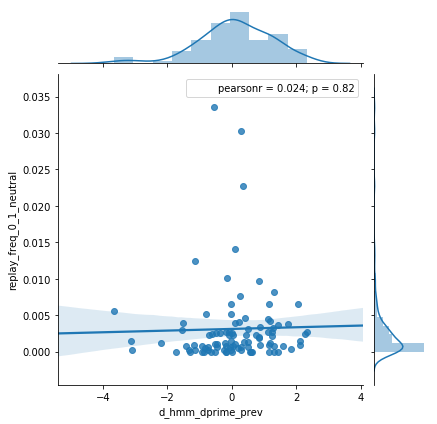

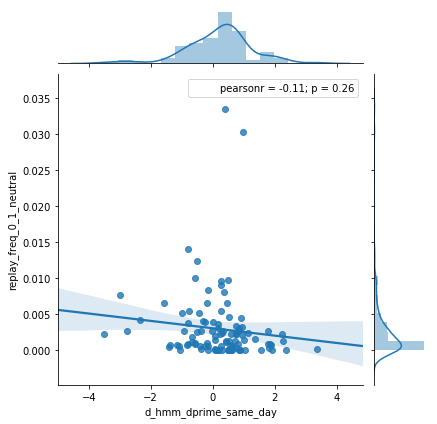

In [19]:
sns.jointplot(
    x='d_hmm_dprime_prev', y='replay_freq_0_1_neutral', data=data, kind='reg',
    truncate=False)
sns.jointplot(
    x='d_hmm_dprime_same_day', y='replay_freq_0_1_neutral', data=data, kind='reg',
    truncate=False)

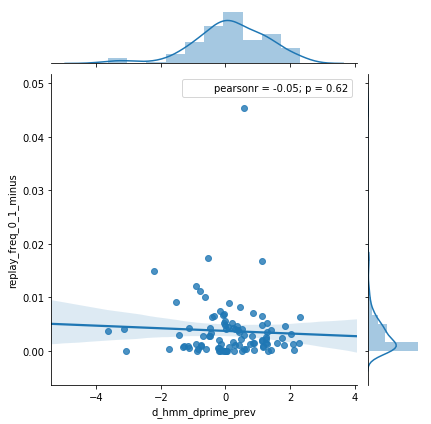

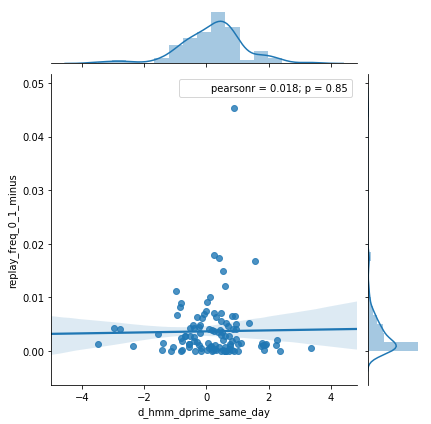

In [20]:
sns.jointplot(
    x='d_hmm_dprime_prev', y='replay_freq_0_1_minus', data=data, kind='reg',
    truncate=False)
sns.jointplot(
    x='d_hmm_dprime_same_day', y='replay_freq_0_1_minus', data=data, kind='reg',
    truncate=False)

## Where is the opposite correlation coming from? Difference in plus/minus behavior? Correlate reactivation with performance on particular trial types
Minus reactivates more when dprime drops, is this driven by plus or minus trials?
## Results:
- Minus reactivation is weakly correlated to changes in trial-specific behavior, but it does seem better correlated with plus trial performance.
- Specifically, minus reactivations are most correlated with a decrease in performance on plus trials (more so than on minus trials)
- All reactivations are correlated much more strongly (inversely) with minus and neutral trial performance than with plus trials.
- Highest rates of reactivations on trials with the most false alarms.

Replay scales poorly with delta behavior or delta HMM behavior

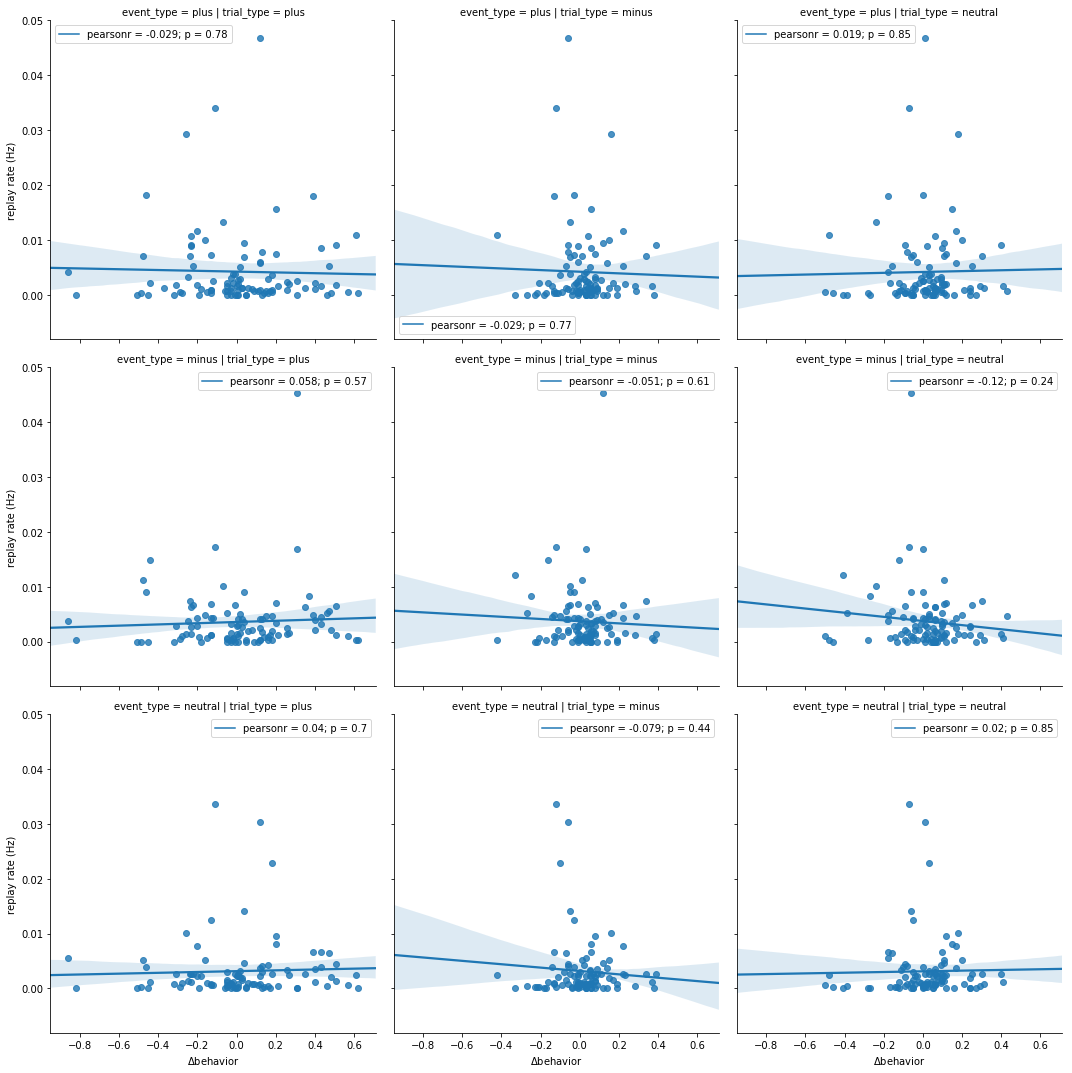

In [21]:
data_long = data[
    ['d_behav_plus_prev', 'd_behav_neutral_prev', 'd_behav_minus_prev',
     'replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus']]
data_long = data_long.melt(
    value_vars=['d_behav_plus_prev', 'd_behav_neutral_prev',
                'd_behav_minus_prev'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
             'replay_freq_0_1_minus'],
    var_name='trial_type', value_name='d_behavior')
data_long.trial_type = data_long.trial_type.map(
    {'d_behav_plus_prev': 'plus', 'd_behav_minus_prev': 'minus',
     'd_behav_neutral_prev': 'neutral'})
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['trial_type', 'd_behavior'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

g = sns.lmplot(
    x='d_behavior', y='events', row='event_type', col='trial_type',
    data=data_long, row_order=order, col_order=order)
g.set_xlabels(r'$\Delta$behavior')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

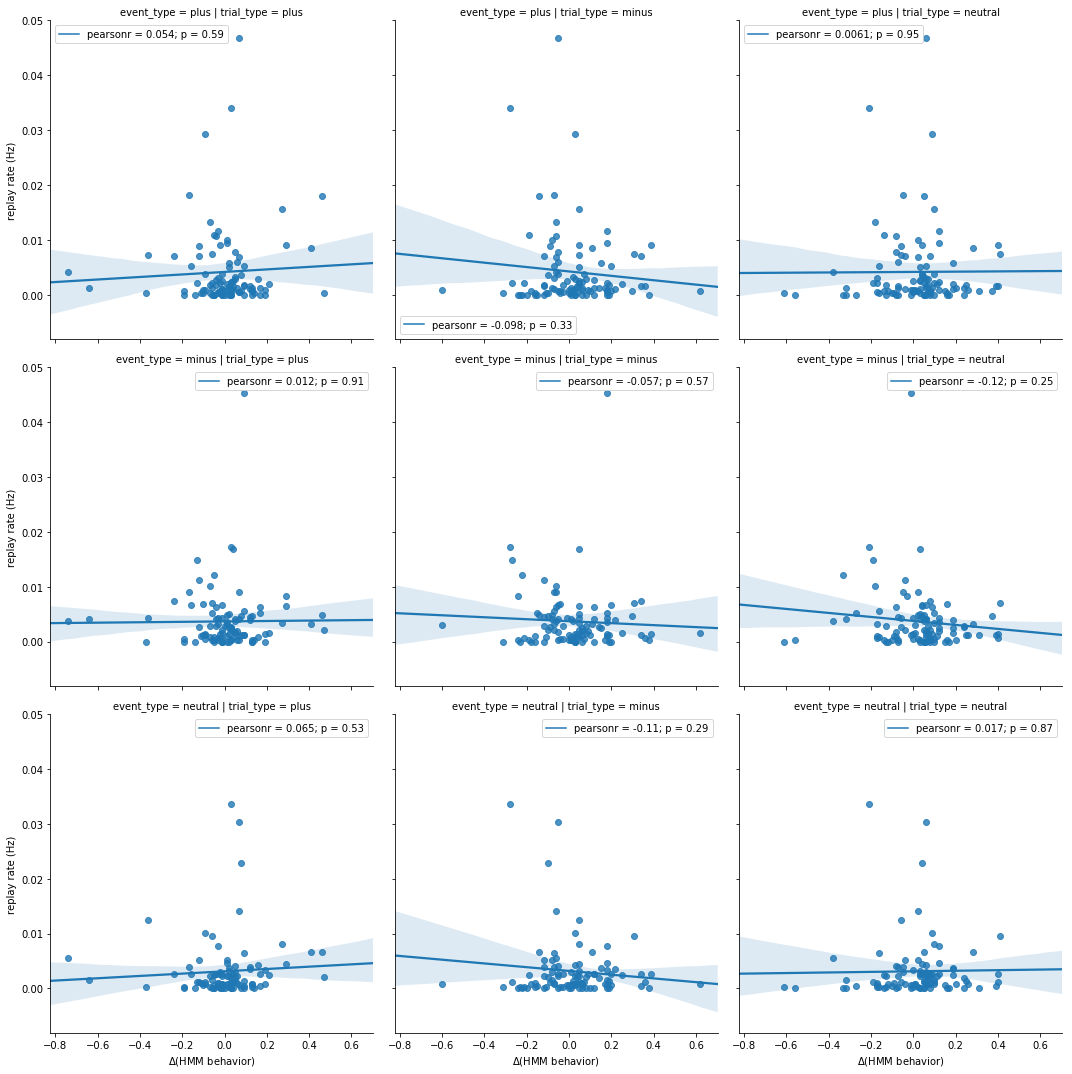

In [22]:
data_long = data[
    ['d_hmm_behav_plus_prev', 'd_hmm_behav_neutral_prev', 'd_hmm_behav_minus_prev',
     'replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus']]
data_long = data_long.melt(
    value_vars=['d_hmm_behav_plus_prev', 'd_hmm_behav_neutral_prev',
                'd_hmm_behav_minus_prev'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
             'replay_freq_0_1_minus'],
    var_name='trial_type', value_name='d_behavior')
data_long.trial_type = data_long.trial_type.map(
    {'d_hmm_behav_plus_prev': 'plus', 'd_hmm_behav_minus_prev': 'minus',
     'd_hmm_behav_neutral_prev': 'neutral'})
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['trial_type', 'd_behavior'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

g = sns.lmplot(
    x='d_behavior', y='events', row='event_type', col='trial_type',
    data=data_long, row_order=order, col_order=order)
g.set_xlabels(r'$\Delta$(HMM behavior)')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

Strongest replay correlations are inverse with behavior on minus and neutral trials - positively with false alarms

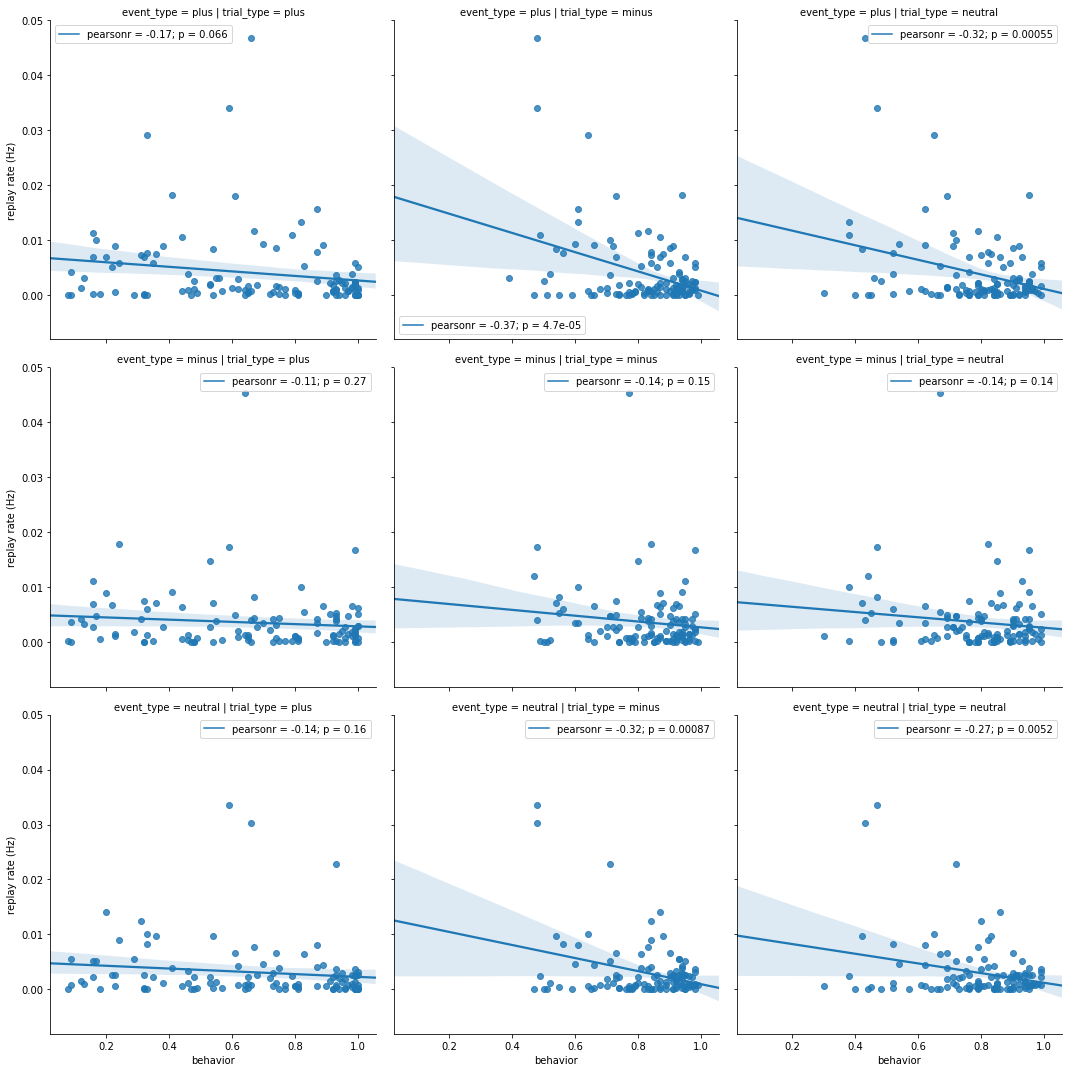

In [23]:
data_long = data[
    ['behavior_plus', 'behavior_neutral', 'behavior_minus',
     'replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus']]
data_long = data_long.melt(
    value_vars=['behavior_plus', 'behavior_neutral', 'behavior_minus'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
             'replay_freq_0_1_minus'],
    var_name='trial_type', value_name='behavior')
data_long.trial_type = data_long.trial_type.map(
    {'behavior_plus': 'plus', 'behavior_minus': 'minus',
     'behavior_neutral': 'neutral'})
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['trial_type', 'behavior'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

g = sns.lmplot(
    x='behavior', y='events', row='event_type', col='trial_type',
    data=data_long, row_order=order, col_order=order)
g.set_xlabels('behavior')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

Pooled across all replay types

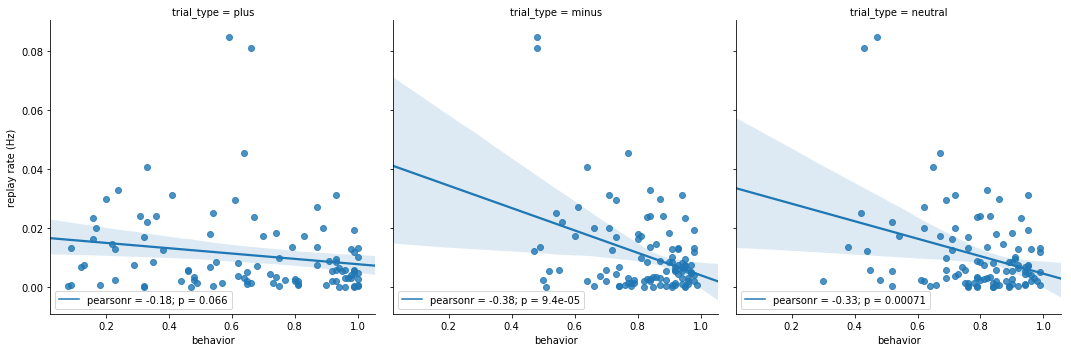

In [24]:
data_long = data[
    ['behavior_plus', 'behavior_neutral', 'behavior_minus',
     'replay_freq_0_1_all']]
data_long = data_long.melt(
    value_vars=['behavior_plus', 'behavior_neutral',
                'behavior_minus'],
    id_vars=['replay_freq_0_1_all'],
    var_name='trial_type', value_name='behavior')
data_long.trial_type = data_long.trial_type.map(
    {'behavior_plus': 'plus', 'behavior_minus': 'minus',
     'behavior_neutral': 'neutral'})

g = sns.lmplot(
    x='behavior', y='replay_freq_0_1_all', col='trial_type',
    data=data_long, row_order=order, col_order=order)
g.set_xlabels('behavior')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

This effect largely goes away when looking at engagement-corrected behavior.
Replay no longer correlates with minus and neutral trials, but now does with plus trials.

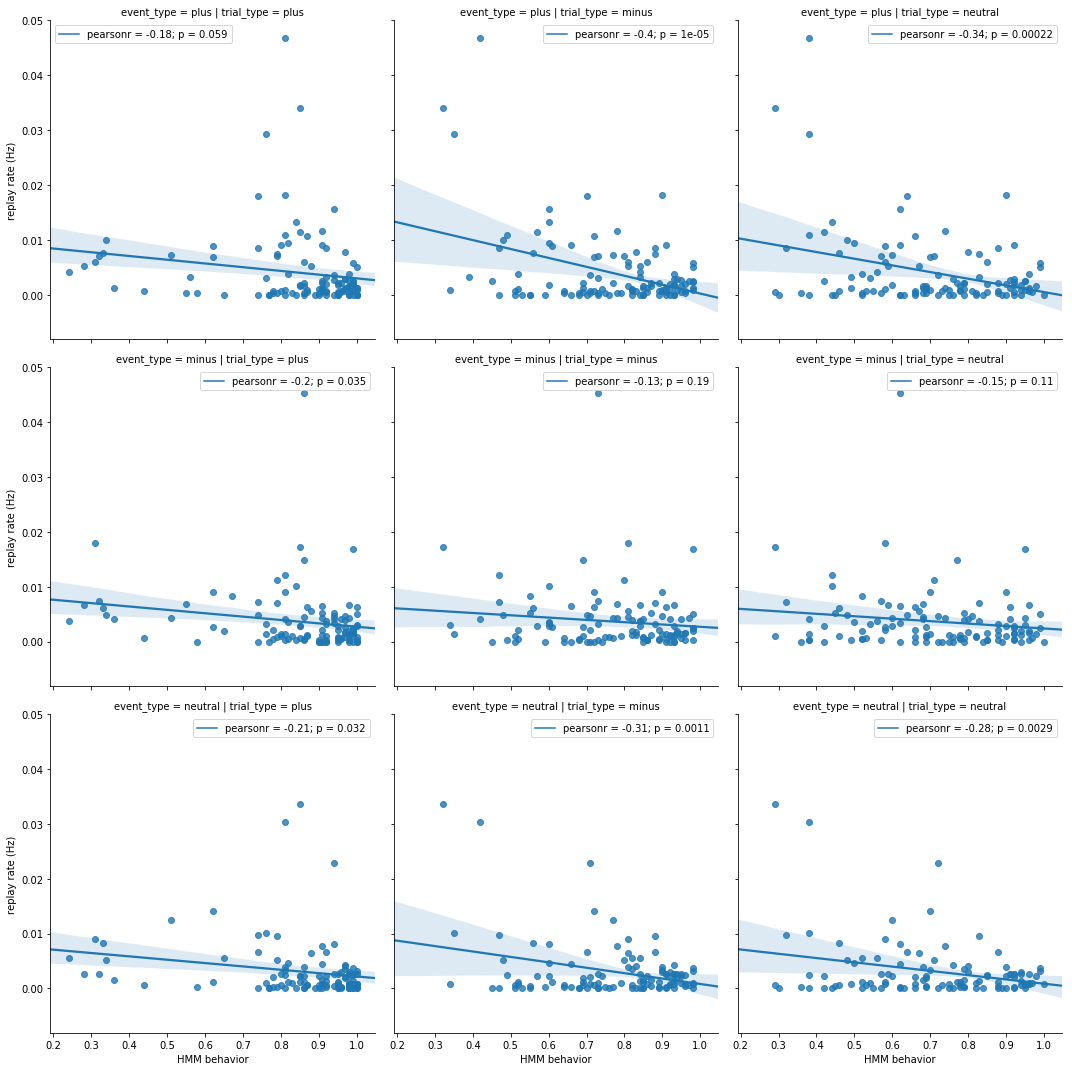

In [25]:
data_long = data[
    ['hmm_behavior_plus', 'hmm_behavior_neutral', 'hmm_behavior_minus',
     'replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus']]
data_long = data_long.melt(
    value_vars=['hmm_behavior_plus', 'hmm_behavior_neutral',
                'hmm_behavior_minus'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
             'replay_freq_0_1_minus'],
    var_name='trial_type', value_name='hmm_behavior')
data_long.trial_type = data_long.trial_type.map(
    {'hmm_behavior_plus': 'plus', 'hmm_behavior_minus': 'minus',
     'hmm_behavior_neutral': 'neutral'})
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['trial_type', 'hmm_behavior'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

g = sns.lmplot(
    x='hmm_behavior', y='events', row='event_type', col='trial_type',
    data=data_long, row_order=order, col_order=order)
g.set_xlabels('HMM behavior')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

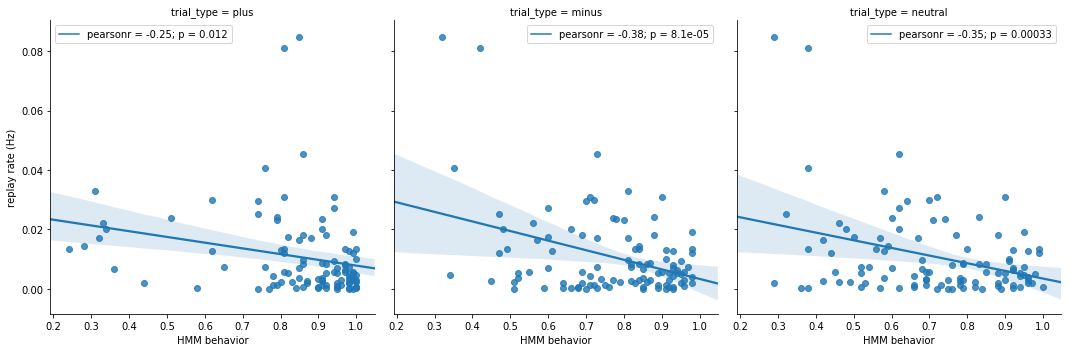

In [26]:
data_long = data[
    ['hmm_behavior_plus', 'hmm_behavior_neutral', 'hmm_behavior_minus',
     'replay_freq_0_1_all']]
data_long = data_long.melt(
    value_vars=['hmm_behavior_plus', 'hmm_behavior_neutral',
                'hmm_behavior_minus'],
    id_vars=['replay_freq_0_1_all'],
    var_name='trial_type', value_name='behavior')
data_long.trial_type = data_long.trial_type.map(
    {'hmm_behavior_plus': 'plus', 'hmm_behavior_minus': 'minus',
     'hmm_behavior_neutral': 'neutral'})

g = sns.lmplot(
    x='behavior', y='replay_freq_0_1_all', col='trial_type',
    data=data_long, row_order=order, col_order=order)
g.set_xlabels('HMM behavior')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

### Do these correlations still exist when correcting for other know factors, specifically engagement and overall performance?

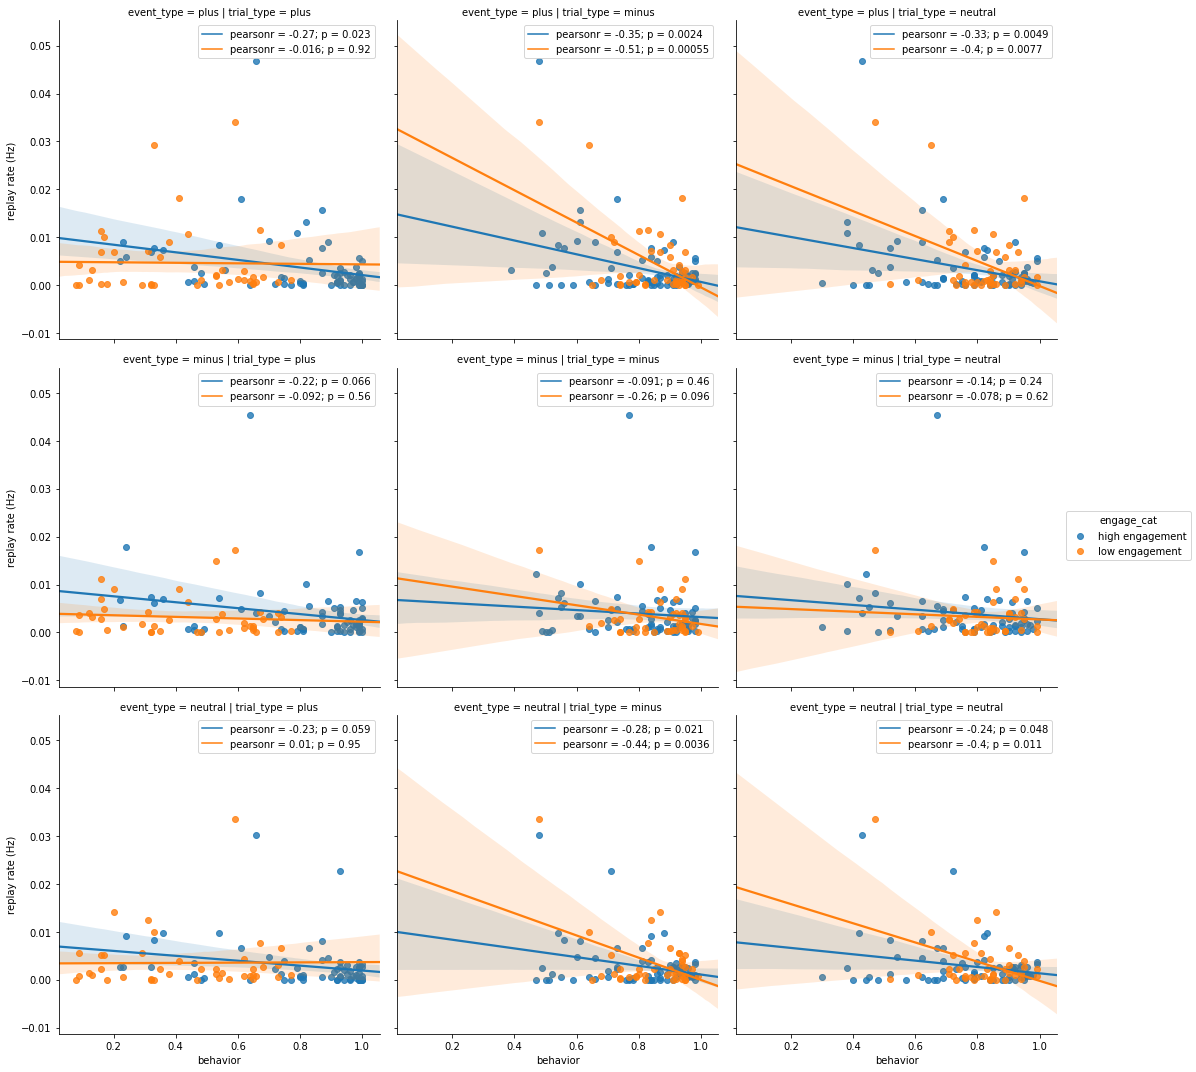

In [27]:
data_long = data[
    ['behavior_plus', 'behavior_neutral', 'behavior_minus',
     'replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus', 'engage_cat']]
data_long = data_long.melt(
    value_vars=['behavior_plus', 'behavior_neutral', 'behavior_minus'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
             'replay_freq_0_1_minus', 'engage_cat'],
    var_name='trial_type', value_name='behavior')
data_long.trial_type = data_long.trial_type.map(
    {'behavior_plus': 'plus', 'behavior_minus': 'minus',
     'behavior_neutral': 'neutral'})
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['trial_type', 'behavior', 'engage_cat'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

g = sns.lmplot(
    x='behavior', y='events', row='event_type', col='trial_type',
    data=data_long, hue='engage_cat', row_order=order, col_order=order)
g.set_xlabels('behavior')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

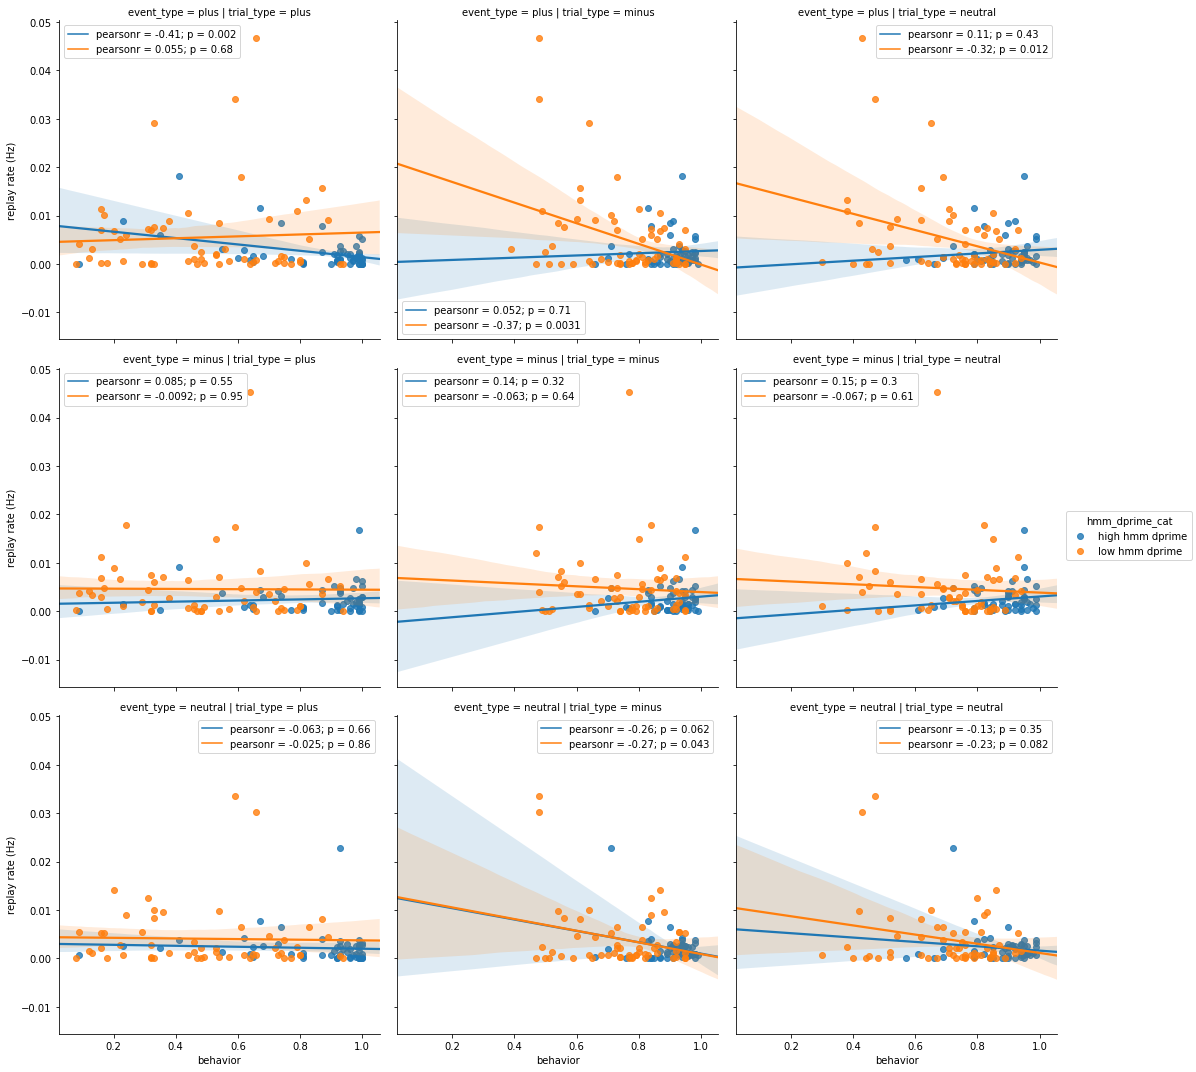

In [28]:
data_long = data[
    ['behavior_plus', 'behavior_neutral', 'behavior_minus',
     'replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus', 'hmm_dprime_cat']]
data_long = data_long.melt(
    value_vars=['behavior_plus', 'behavior_neutral', 'behavior_minus'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
             'replay_freq_0_1_minus', 'hmm_dprime_cat'],
    var_name='trial_type', value_name='behavior')
data_long.trial_type = data_long.trial_type.map(
    {'behavior_plus': 'plus', 'behavior_minus': 'minus',
     'behavior_neutral': 'neutral'})
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['trial_type', 'behavior', 'hmm_dprime_cat'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

g = sns.lmplot(
    x='behavior', y='events', row='event_type', col='trial_type',
    data=data_long, hue='hmm_dprime_cat', row_order=order, col_order=order)
g.set_xlabels('behavior')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

### Regress out engagement and dprime from reactivation rate

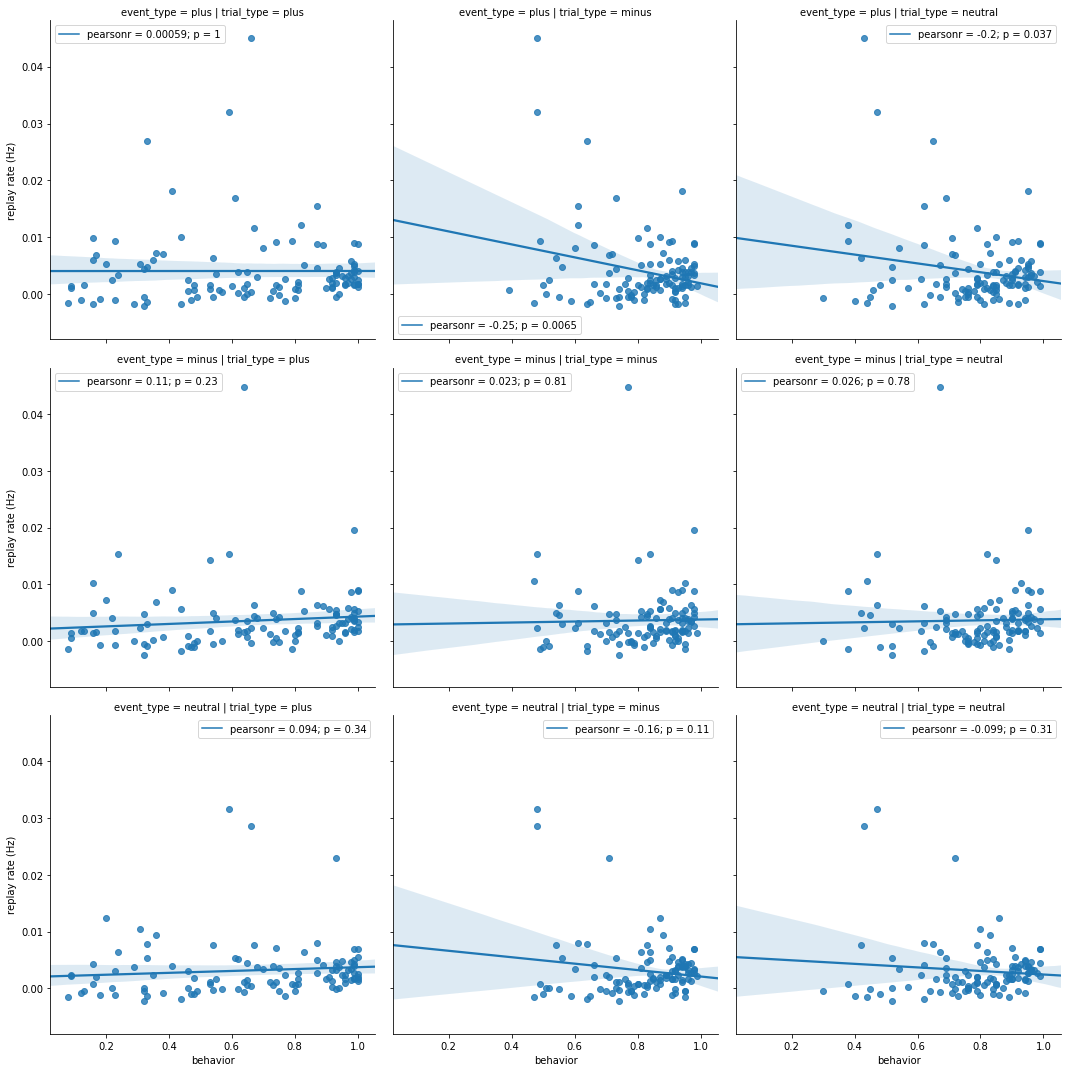

In [29]:
data_long = data[
    ['behavior_plus', 'behavior_neutral', 'behavior_minus',
     'replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus', 'hmm_engagement', 'hmm_dprime']]
data_long = data_long.melt(
    value_vars=['behavior_plus', 'behavior_neutral', 'behavior_minus'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
             'replay_freq_0_1_minus', 'hmm_engagement', 'hmm_dprime'],
    var_name='trial_type', value_name='behavior')
data_long.trial_type = data_long.trial_type.map(
    {'behavior_plus': 'plus', 'behavior_minus': 'minus',
     'behavior_neutral': 'neutral'})
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['trial_type', 'behavior', 'hmm_engagement', 'hmm_dprime'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

data_long.dropna(subset=['events', 'behavior'], inplace=True)
data_long = data_long.assign(
    events_minus_engage=jzap.analysis.regress_out(
        data_long.events, data_long.hmm_engagement))
data_long = data_long.assign(
    events_minus_engage_minus_dprime=jzap.analysis.regress_out(
        data_long.events_minus_engage, data_long.hmm_dprime))

g = sns.lmplot(
    x='behavior', y='events_minus_engage_minus_dprime', row='event_type',
    col='trial_type', data=data_long, row_order=order, col_order=order)
g.set_xlabels('behavior')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

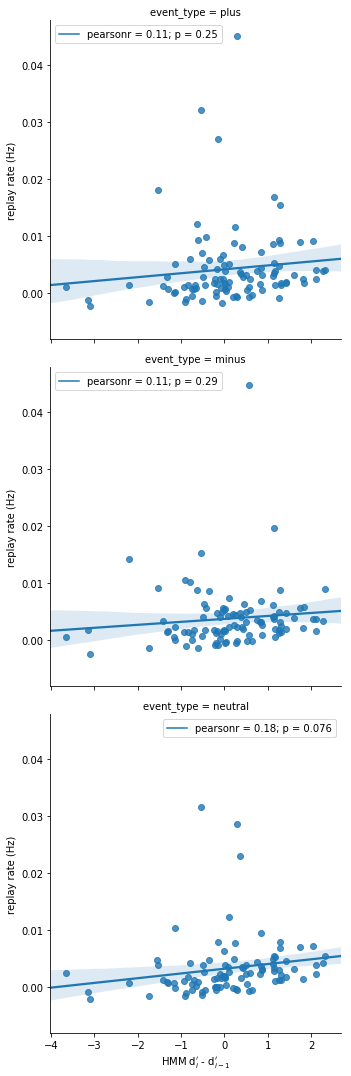

In [30]:
data_long = data[
    ['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus', 'hmm_engagement', 'hmm_dprime',
     'd_hmm_dprime_prev']]
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['hmm_engagement', 'hmm_dprime',
             'd_hmm_dprime_prev'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

data_long.dropna(subset=['events', 'hmm_engagement', 'hmm_dprime'], inplace=True)
data_long = data_long.assign(
    events_minus_engage=jzap.analysis.regress_out(
        data_long.events, data_long.hmm_engagement))
data_long = data_long.assign(
    events_minus_engage_minus_dprime=jzap.analysis.regress_out(
        data_long.events_minus_engage, data_long.hmm_dprime))

g = sns.lmplot(
    x='d_hmm_dprime_prev', y='events_minus_engage_minus_dprime', row='event_type',
    data=data_long, row_order=order, col_order=order)
g.set_xlabels(r'HMM d$^\prime_{i}$ - d$^\prime_{i-1}$')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

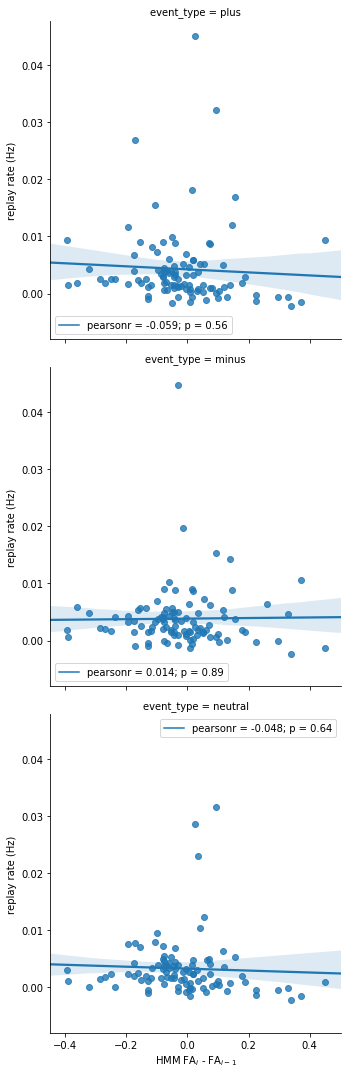

In [31]:
data_long = data[
    ['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus', 'hmm_engagement', 'hmm_dprime',
     'd_fa_prev']]

data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['hmm_engagement', 'hmm_dprime',
             'd_fa_prev'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

data_long.dropna(subset=['events', 'hmm_engagement', 'hmm_dprime'], inplace=True)
data_long = data_long.assign(
    events_minus_engage=jzap.analysis.regress_out(
        data_long.events, data_long.hmm_engagement))
data_long = data_long.assign(
    events_minus_engage_minus_dprime=jzap.analysis.regress_out(
        data_long.events_minus_engage, data_long.hmm_dprime))

g = sns.lmplot(
    x='d_fa_prev', y='events_minus_engage_minus_dprime', row='event_type',
    data=data_long, row_order=order, col_order=order)
g.set_xlabels(r'HMM FA$_{i}$ - FA$_{i-1}$')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

### FA rate vs. miss rate

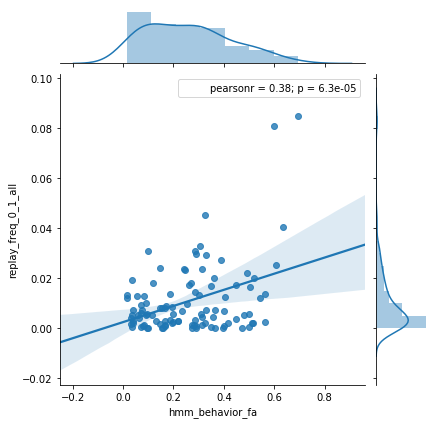

In [32]:
sns.jointplot(
    y='replay_freq_0_1_all', x='hmm_behavior_fa', data=data, kind='reg')

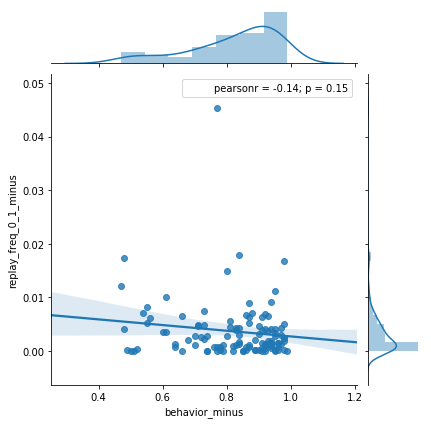

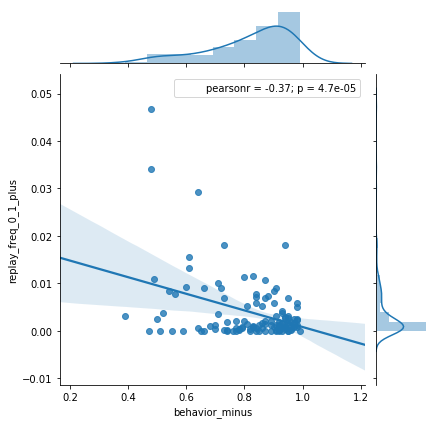

In [33]:
sns.jointplot(
    y='replay_freq_0_1_minus', x='behavior_minus', data=data, kind='reg')
sns.jointplot(
    y='replay_freq_0_1_plus', x='behavior_minus', data=data, kind='reg')

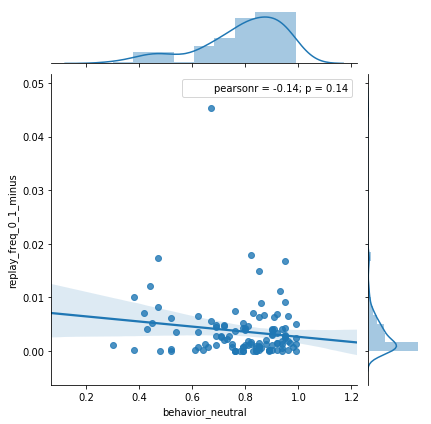

In [34]:
sns.jointplot(
    y='replay_freq_0_1_minus', x='behavior_neutral', data=data, kind='reg')

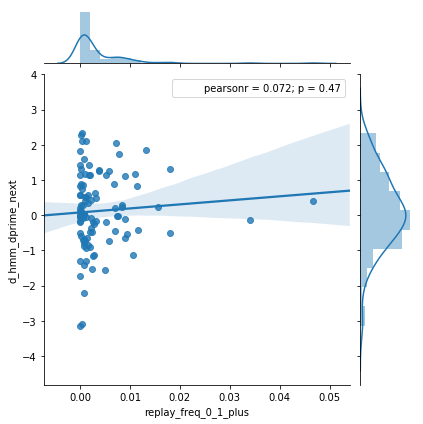

In [35]:
sns.jointplot(
    y='d_hmm_dprime_next', x='replay_freq_0_1_plus', data=data, kind='reg')

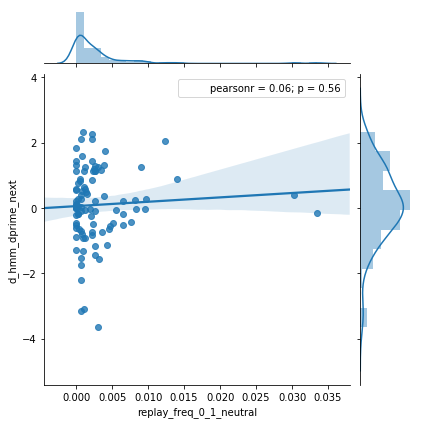

In [36]:
sns.jointplot(
    y='d_hmm_dprime_next', x='replay_freq_0_1_neutral', data=data, kind='reg')

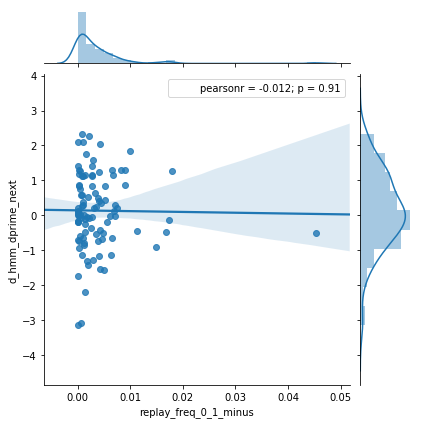

In [37]:
sns.jointplot(
    y='d_hmm_dprime_next', x='replay_freq_0_1_minus', data=data, kind='reg')

Mark:
As a note on this: I think it makes a lot of sense: we train our animals on CSp for many days, and then start recording on the day (roughly) when we introduce CSn and CSm. I think that the animal's strategy, given this, is likely to be learning suppression to the non-CSp trials, having previously learned that CSp is good (ie learned it well before the collected datasets). This may be extreme, but is useful to keep in mind. 

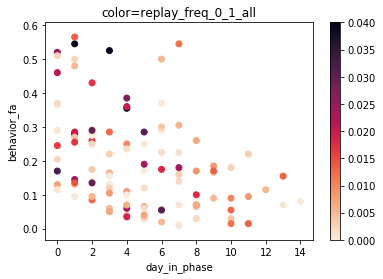

In [38]:
x = 'day_in_phase'
y = 'behavior_fa'
hue = 'replay_freq_0_1_all'
# cmap = sns.cubehelix_palette(light=0.85, dark=0.15, as_cmap=True)
cmap = sns.cm.rocket_r

fig, ax = plt.subplots()
data_no_nan = data[[x, y, hue]]
data_no_nan.dropna(inplace=True)
x_data = np.array(data_no_nan[x])
y_data = np.array(data_no_nan[y])
hue_data = np.array(data_no_nan[hue])

plt.scatter(x_data, y_data, c=hue_data, cmap=cmap, vmax=0.04)
plt.colorbar(ax=ax)
plt.xlabel(x)
plt.ylabel(y)
plt.title('color={}'.format(hue));

# rect = plt.Rectangle((-0.75, -1), 2.65, 2.7, fill=False, color='g')
# ax.add_patch(rect);

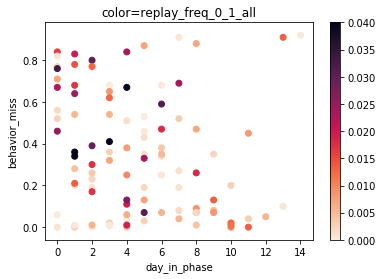

In [39]:
x = 'day_in_phase'
y = 'behavior_miss'
hue = 'replay_freq_0_1_all'
# cmap = sns.cubehelix_palette(light=0.85, dark=0.15, as_cmap=True)
cmap = sns.cm.rocket_r

fig, ax = plt.subplots()
data_no_nan = data[[x, y, hue]]
data_no_nan.dropna(inplace=True)
x_data = np.array(data_no_nan[x])
y_data = np.array(data_no_nan[y])
hue_data = np.array(data_no_nan[hue])

plt.scatter(x_data, y_data, c=hue_data, cmap=cmap, vmax=0.04)
plt.colorbar(ax=ax)
plt.xlabel(x)
plt.ylabel(y)
plt.title('color={}'.format(hue));

### Split data by elapsed day and plot delta days 1-3

### Change in task performance followed by replay events
#### d_day=3 is actually 3+ 

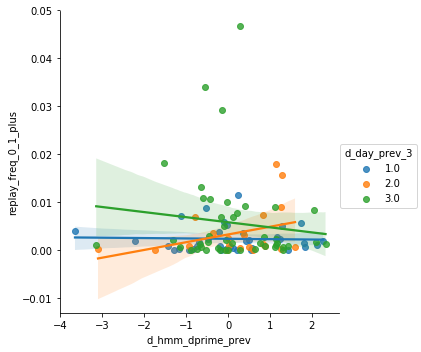

In [40]:
sns.lmplot(
    x='d_hmm_dprime_prev', y='replay_freq_0_1_plus', data=data,
    hue='d_day_prev_3', truncate=True, legend=True)

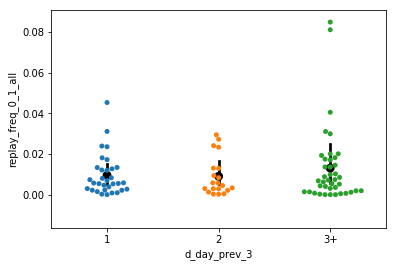

In [41]:
_, ax = plt.subplots()
sns.swarmplot(x='d_day_prev_3', y='replay_freq_0_1_all', data=data)
sns.pointplot(
    x='d_day_prev_3', y='replay_freq_0_1_all', data=data, units='mouse',
    color='k', join=False)
ax.set_xticklabels(['1', '2', '3+']);

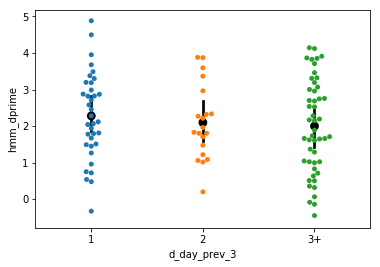

In [42]:
_, ax = plt.subplots()
sns.swarmplot(x='d_day_prev_3', y='hmm_dprime', data=data)
sns.pointplot(
    x='d_day_prev_3', y='hmm_dprime', data=data, units='mouse',
    color='k', join=False)
ax.set_xticklabels(['1', '2', '3+']);

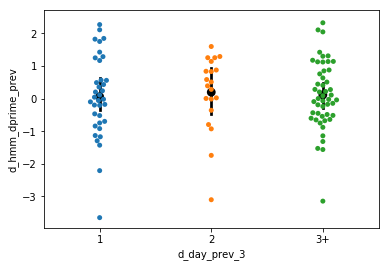

In [43]:
_, ax = plt.subplots()
sns.swarmplot(x='d_day_prev_3', y='d_hmm_dprime_prev', data=data)
sns.pointplot(
    x='d_day_prev_3', y='d_hmm_dprime_prev', data=data, units='mouse',
    color='k', join=False)
ax.set_xticklabels(['1', '2', '3+']);

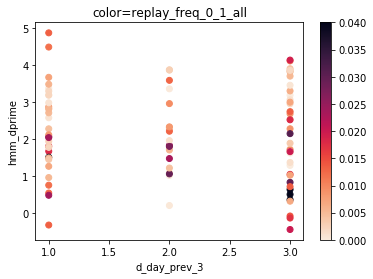

In [76]:
x = 'd_day_prev_3'
y = 'hmm_dprime'
hue = 'replay_freq_0_1_all'
# cmap = sns.cubehelix_palette(light=0.85, dark=0.15, as_cmap=True)
cmap = sns.cm.rocket_r

fig, ax = plt.subplots()
data_no_nan = data[[x, y, hue]]
data_no_nan.dropna(inplace=True)
x_data = np.array(data_no_nan[x])
y_data = np.array(data_no_nan[y])
hue_data = np.array(data_no_nan[hue])

plt.scatter(x_data, y_data, c=hue_data, cmap=cmap, vmax=0.04)
plt.colorbar(ax=ax)
plt.xlabel(x)
plt.ylabel(y)
plt.title('color={}'.format(hue));

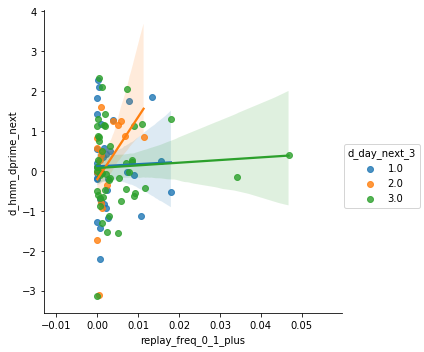

In [44]:
sns.lmplot(
    y='d_hmm_dprime_next', x='replay_freq_0_1_plus',
    data=data, hue='d_day_next_3', truncate=True,
    legend=True)

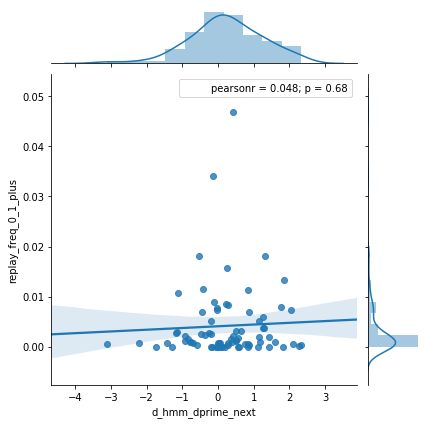

In [45]:
sns.jointplot(
    x='d_hmm_dprime_next', y='replay_freq_0_1_plus',
    data=data[data['d_day_next'] < 4], kind='reg')

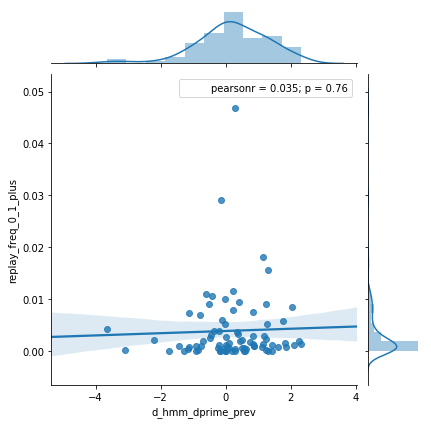

In [46]:
sns.jointplot(
    x='d_hmm_dprime_prev', y='replay_freq_0_1_plus',
    data=data[data['d_day_prev'] < 4], kind='reg')

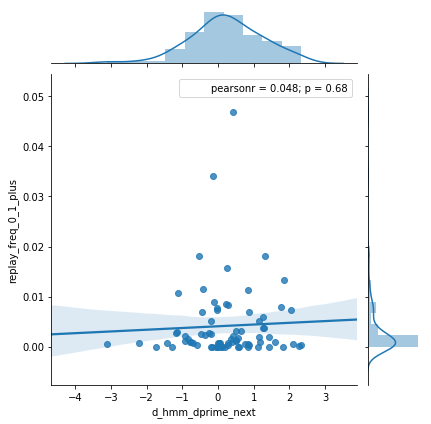

In [47]:
sns.jointplot(
    x='d_hmm_dprime_next', y='replay_freq_0_1_plus',
    data=data[data['d_day_next'] < 4], kind='reg')

## Autocorrelation of task performance

In [48]:
data_filled = jzap.misc.fill_dates(data, 'date', unit='phase_mouse')

In [49]:
autocorr_date = jzap.analysis.core.xcorr(
    data_filled, 'hmm_dprime', 'hmm_dprime', unit='phase_mouse', time='date',
    method='pearson', max_lag=5)
autocorr_day = jzap.analysis.core.xcorr(
    data, 'hmm_dprime', 'hmm_dprime', unit='phase_mouse', time='day_in_phase',
    method='pearson', max_lag=5)

### Behavior autocorrelation by date

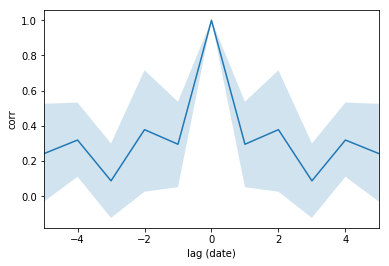

In [50]:
fig, ax = plt.subplots()
sns.tsplot(
    autocorr_date, time='lag (date)', unit='phase_mouse', value='corr',
    err_style='ci_band', estimator=np.nanmean, ax=ax)

### Behavior autocorrelation by day/session (ignores days between sessions)

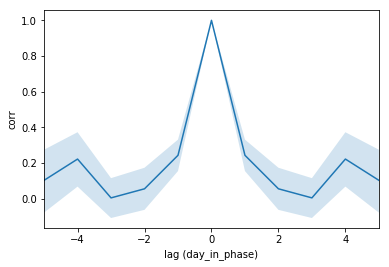

In [51]:
fig, ax = plt.subplots()
sns.tsplot(
    autocorr_day, time='lag (day_in_phase)', unit='phase_mouse', value='corr',
    err_style='ci_band', estimator=np.nanmean, ax=ax)

### Cross-correlation of perfromance and reactivations (by date and by session)

In [52]:
xcorr_date = jzap.analysis.core.xcorr(
    data_filled, 'hmm_dprime', 'replay_freq_0_1_plus', unit='phase_mouse',
    time='date', method='pearson', max_lag=5)
xcorr_day = jzap.analysis.core.xcorr(
    data, 'hmm_dprime', 'replay_freq_0_1_plus', unit='phase_mouse',
    time='day_in_phase', method='pearson', max_lag=5)

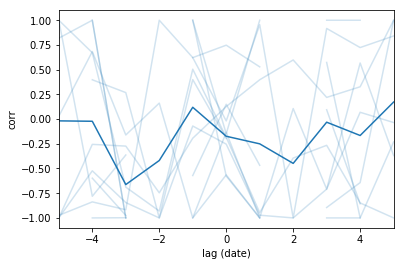

In [53]:
fig, ax = plt.subplots()
sns.tsplot(
    xcorr_date, time='lag (date)', unit='phase_mouse', value='corr',
    err_style='unit_traces', estimator=np.nanmean, ax=ax)

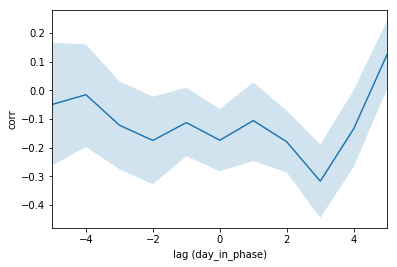

In [54]:
fig, ax = plt.subplots()
sns.tsplot(
    xcorr_day, time='lag (day_in_phase)', unit='phase_mouse', value='corr',
    err_style='ci_band', estimator=np.nanmean, ax=ax)

## Split by pre and post reversal

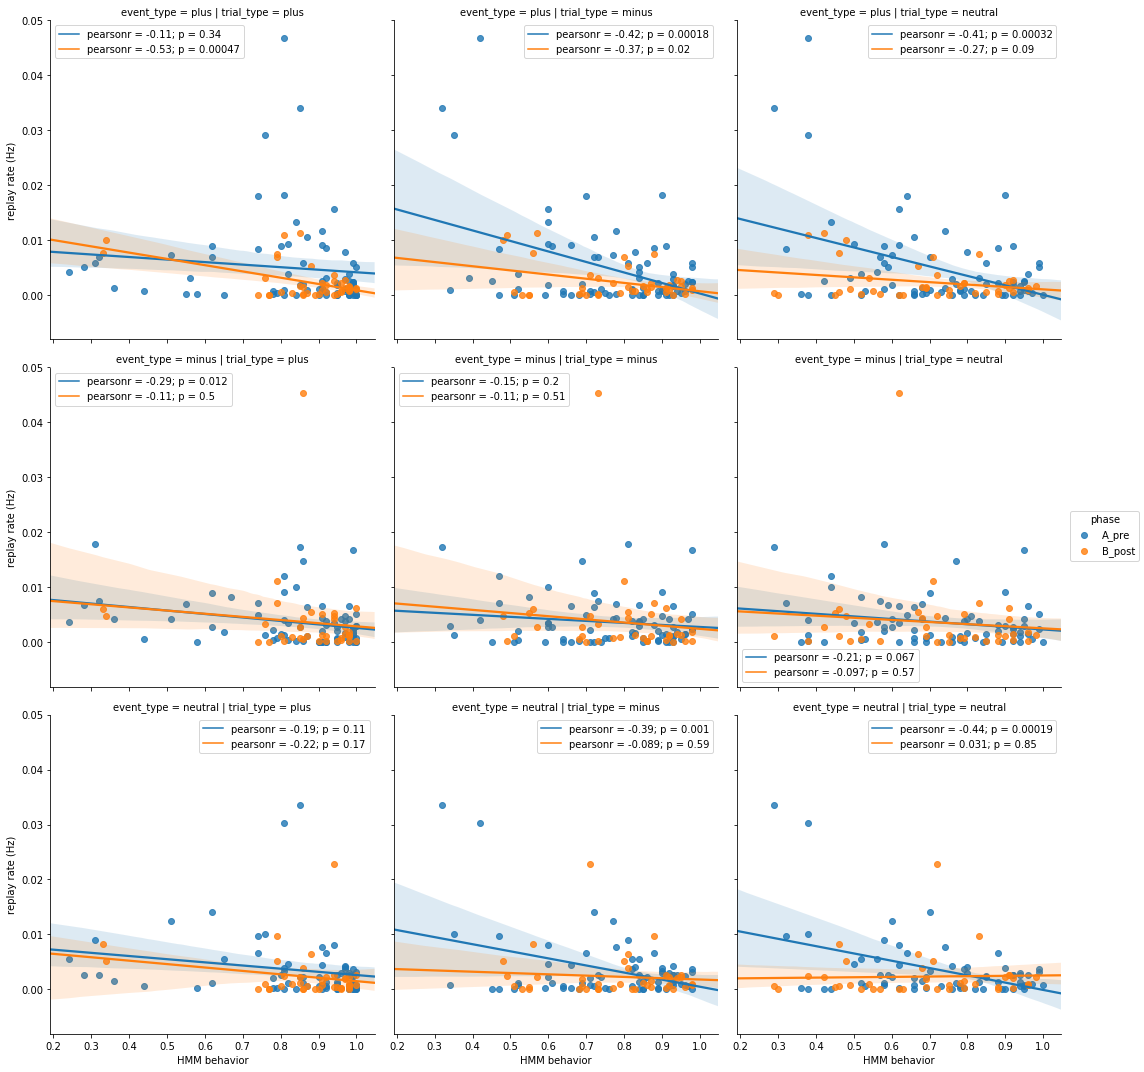

In [55]:
data_long = data[
    ['hmm_behavior_plus', 'hmm_behavior_neutral', 'hmm_behavior_minus',
     'replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus', 'phase']]
data_long = data_long.melt(
    value_vars=['hmm_behavior_plus', 'hmm_behavior_neutral', 'hmm_behavior_minus'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
             'replay_freq_0_1_minus', 'phase'],
    var_name='trial_type', value_name='behavior')
data_long.trial_type = data_long.trial_type.map(
    {'hmm_behavior_plus': 'plus', 'hmm_behavior_minus': 'minus',
     'hmm_behavior_neutral': 'neutral'})
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['trial_type', 'behavior', 'phase'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

g = sns.lmplot(
    x='behavior', y='events', row='event_type', col='trial_type',
    data=data_long, hue='phase', row_order=order, col_order=order)
g.set_xlabels('HMM behavior')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

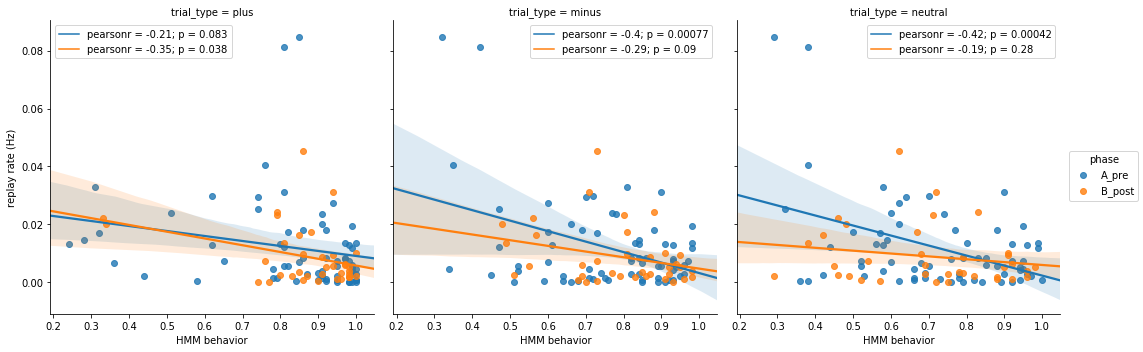

In [56]:
data_long = data[
    ['hmm_behavior_plus', 'hmm_behavior_neutral', 'hmm_behavior_minus',
     'replay_freq_0_1_all', 'phase']]
data_long = data_long.melt(
    value_vars=['hmm_behavior_plus', 'hmm_behavior_neutral', 'hmm_behavior_minus'],
    id_vars=['replay_freq_0_1_all', 'phase'],
    var_name='trial_type', value_name='behavior')
data_long.trial_type = data_long.trial_type.map(
    {'hmm_behavior_plus': 'plus', 'hmm_behavior_minus': 'minus',
     'hmm_behavior_neutral': 'neutral'})

g = sns.lmplot(
    x='behavior', y='replay_freq_0_1_all', col='trial_type',
    data=data_long, hue='phase', row_order=order, col_order=order)
g.set_xlabels('HMM behavior')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

## Trial counts instead of rates

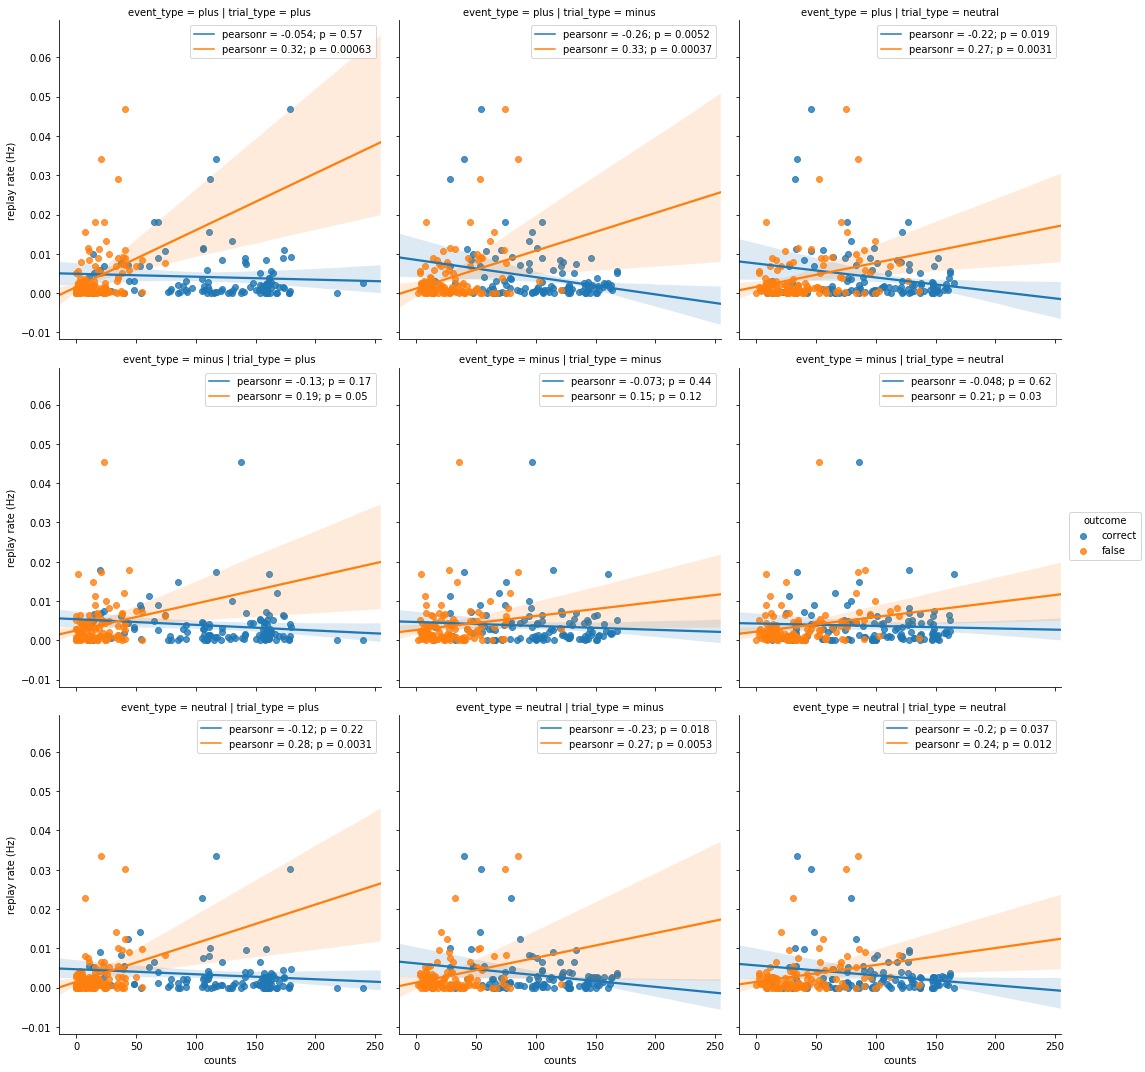

In [58]:
data_long = data[
    ['hmm_ncorrect_plus', 'hmm_nfalse_plus', 'hmm_ncorrect_minus', 'hmm_nfalse_minus', 'hmm_ncorrect_neutral', 'hmm_nfalse_neutral',
     'replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus']]
data_long = data_long.melt(
    value_vars=['hmm_ncorrect_plus', 'hmm_ncorrect_neutral',
                'hmm_ncorrect_minus', 'hmm_nfalse_plus', 'hmm_nfalse_minus',
                'hmm_nfalse_neutral'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
             'replay_freq_0_1_minus'],
    var_name='trial', value_name='counts')
outcome = data_long.trial.apply(
    lambda x: 'correct' if 'correct' in x else 'false' if 'false' in x else 'ERROR')
trial_type = data_long.trial.apply(
    lambda x: 'plus' if 'plus' in x else 'minus' if 'minus' in x else 'neutral' if 'neutral' in x else 'ERROR')
data_long = data_long.assign(outcome=outcome, trial_type=trial_type)
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['trial_type', 'counts', 'outcome'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

g = sns.lmplot(
    x='counts', y='events', row='event_type', col='trial_type',
    data=data_long, row_order=order, col_order=order, hue='outcome')
g.set_xlabels('counts')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

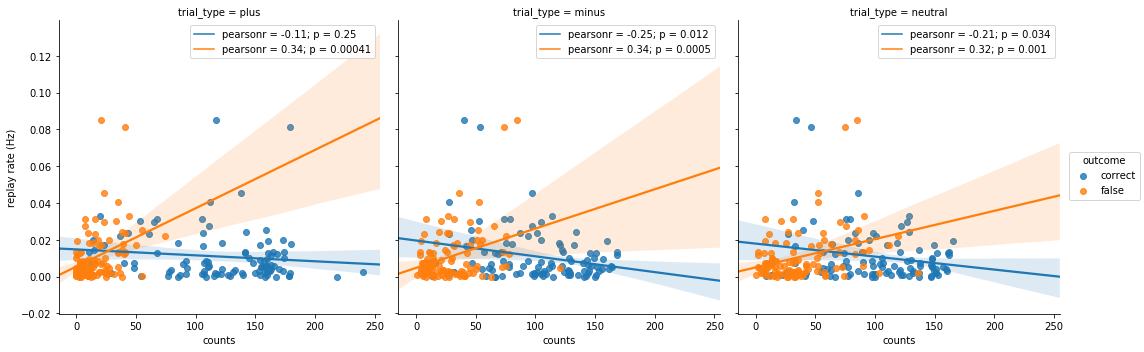

In [59]:
data_long = data[
    ['hmm_ncorrect_plus', 'hmm_nfalse_plus', 'hmm_ncorrect_minus', 'hmm_nfalse_minus', 'hmm_ncorrect_neutral', 'hmm_nfalse_neutral',
     'replay_freq_0_1_all']]
data_long = data_long.melt(
    value_vars=['hmm_ncorrect_plus', 'hmm_ncorrect_neutral',
                'hmm_ncorrect_minus', 'hmm_nfalse_plus', 'hmm_nfalse_minus',
                'hmm_nfalse_neutral'],
    id_vars=['replay_freq_0_1_all'],
    var_name='trial', value_name='counts')
outcome = data_long.trial.apply(
    lambda x: 'correct' if 'correct' in x else 'false' if 'false' in x else 'ERROR')
trial_type = data_long.trial.apply(
    lambda x: 'plus' if 'plus' in x else 'minus' if 'minus' in x else 'neutral' if 'neutral' in x else 'ERROR')
data_long = data_long.assign(outcome=outcome, trial_type=trial_type)

g = sns.lmplot(
    x='counts', y='replay_freq_0_1_all', col='trial_type',
    data=data_long, col_order=order, hue='outcome')
g.set_xlabels('counts')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

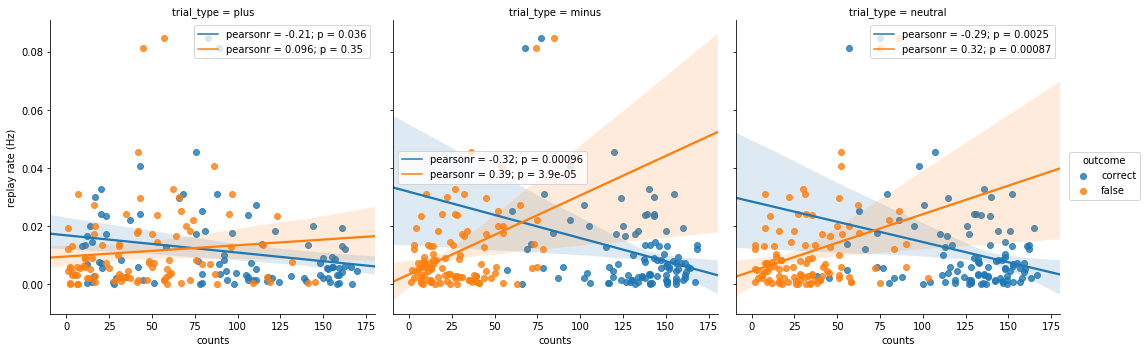

In [60]:
data_long = data[
    ['ncorrect_plus', 'nfalse_plus', 'ncorrect_minus', 'nfalse_minus', 'ncorrect_neutral', 'nfalse_neutral',
     'replay_freq_0_1_all']]
data_long = data_long.melt(
    value_vars=['ncorrect_plus', 'ncorrect_neutral',
                'ncorrect_minus', 'nfalse_plus', 'nfalse_minus',
                'nfalse_neutral'],
    id_vars=['replay_freq_0_1_all'],
    var_name='trial', value_name='counts')
outcome = data_long.trial.apply(
    lambda x: 'correct' if 'correct' in x else 'false' if 'false' in x else 'ERROR')
trial_type = data_long.trial.apply(
    lambda x: 'plus' if 'plus' in x else 'minus' if 'minus' in x else 'neutral' if 'neutral' in x else 'ERROR')
data_long = data_long.assign(outcome=outcome, trial_type=trial_type)

g = sns.lmplot(
    x='counts', y='replay_freq_0_1_all', col='trial_type',
    data=data_long, col_order=order, hue='outcome')
g.set_xlabels('counts')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

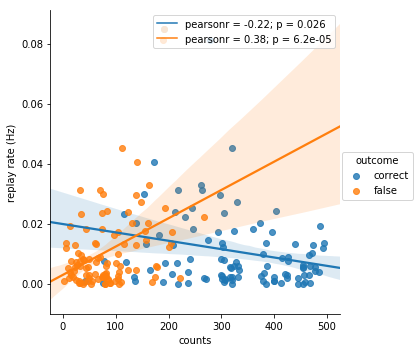

In [61]:
data_long = data[
    ['hmm_ncorrect_all', 'hmm_nfalse_all', 'replay_freq_0_1_all']]
data_long = data_long.melt(
    value_vars=['hmm_ncorrect_all', 'hmm_nfalse_all'],
    id_vars=['replay_freq_0_1_all'],
    var_name='outcome', value_name='counts')
data_long.outcome = data_long.outcome.apply(
    lambda x: 'correct' if 'correct' in x else 'false' if 'false' in x else 'ERROR')

g = sns.lmplot(
    x='counts', y='replay_freq_0_1_all',
    data=data_long, col_order=order, hue='outcome')
g.set_xlabels('counts')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

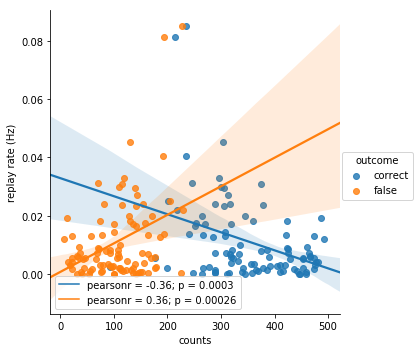

In [62]:
data_long = data[
    ['replay_freq_0_1_all', 'nfalse_plus', 'nfalse_minus', 'nfalse_neutral',
     'ncorrect_plus', 'ncorrect_minus', 'ncorrect_neutral']]
# HACK
data_long['nfalse_all'] = data_long.nfalse_plus + data_long.nfalse_minus + data_long.nfalse_neutral
data_long['ncorrect_all'] = data_long.ncorrect_plus + data_long.ncorrect_minus + data_long.ncorrect_neutral
data_long = data_long.melt(
    value_vars=['ncorrect_all', 'nfalse_all'],
    id_vars=['replay_freq_0_1_all'],
    var_name='outcome', value_name='counts')
data_long.outcome = data_long.outcome.apply(
    lambda x: 'correct' if 'correct' in x else 'false' if 'false' in x else 'ERROR')

g = sns.lmplot(
    x='counts', y='replay_freq_0_1_all',
    data=data_long, col_order=order, hue='outcome')
g.set_xlabels('counts')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

### zscore data first

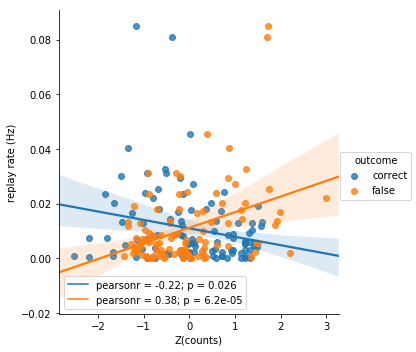

In [63]:
from scipy.stats.mstats import zscore
data_long = data[
    ['hmm_ncorrect_all', 'hmm_nfalse_all', 'replay_freq_0_1_all']]
data_long = data_long.assign(hmm_ncorrect_all=zscore(data_long.hmm_ncorrect_all),
                 hmm_nfalse_all=zscore(data_long.hmm_nfalse_all))
data_long = data_long.melt(
    value_vars=['hmm_ncorrect_all', 'hmm_nfalse_all'],
    id_vars=['replay_freq_0_1_all'],
    var_name='outcome', value_name='counts')
data_long.outcome = data_long.outcome.apply(
    lambda x: 'correct' if 'correct' in x else 'false' if 'false' in x else 'ERROR')

g = sns.lmplot(
    x='counts', y='replay_freq_0_1_all',
    data=data_long, col_order=order, hue='outcome')
g.set_xlabels('Z(counts)')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

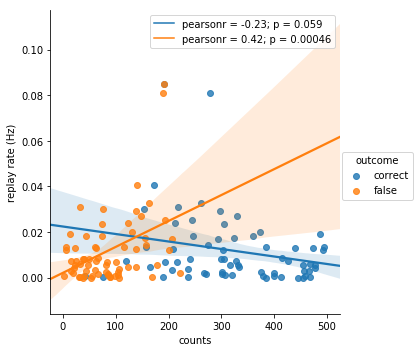

In [64]:
data_long = pre_data[
    ['hmm_ncorrect_all', 'hmm_nfalse_all', 'replay_freq_0_1_all']]
data_long = data_long.melt(
    value_vars=['hmm_ncorrect_all', 'hmm_nfalse_all'],
    id_vars=['replay_freq_0_1_all'],
    var_name='outcome', value_name='counts')
data_long.outcome = data_long.outcome.apply(
    lambda x: 'correct' if 'correct' in x else 'false' if 'false' in x else 'ERROR')

g = sns.lmplot(
    x='counts', y='replay_freq_0_1_all',
    data=data_long, col_order=order, hue='outcome')
g.set_xlabels('counts')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

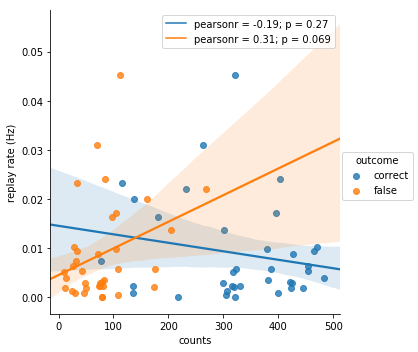

In [65]:
data_long = post_data[
    ['hmm_ncorrect_all', 'hmm_nfalse_all', 'replay_freq_0_1_all']]
data_long = data_long.melt(
    value_vars=['hmm_ncorrect_all', 'hmm_nfalse_all'],
    id_vars=['replay_freq_0_1_all'],
    var_name='outcome', value_name='counts')
data_long.outcome = data_long.outcome.apply(
    lambda x: 'correct' if 'correct' in x else 'false' if 'false' in x else 'ERROR')

g = sns.lmplot(
    x='counts', y='replay_freq_0_1_all',
    data=data_long, col_order=order, hue='outcome')
g.set_xlabels('counts')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

# replay predicting behavior

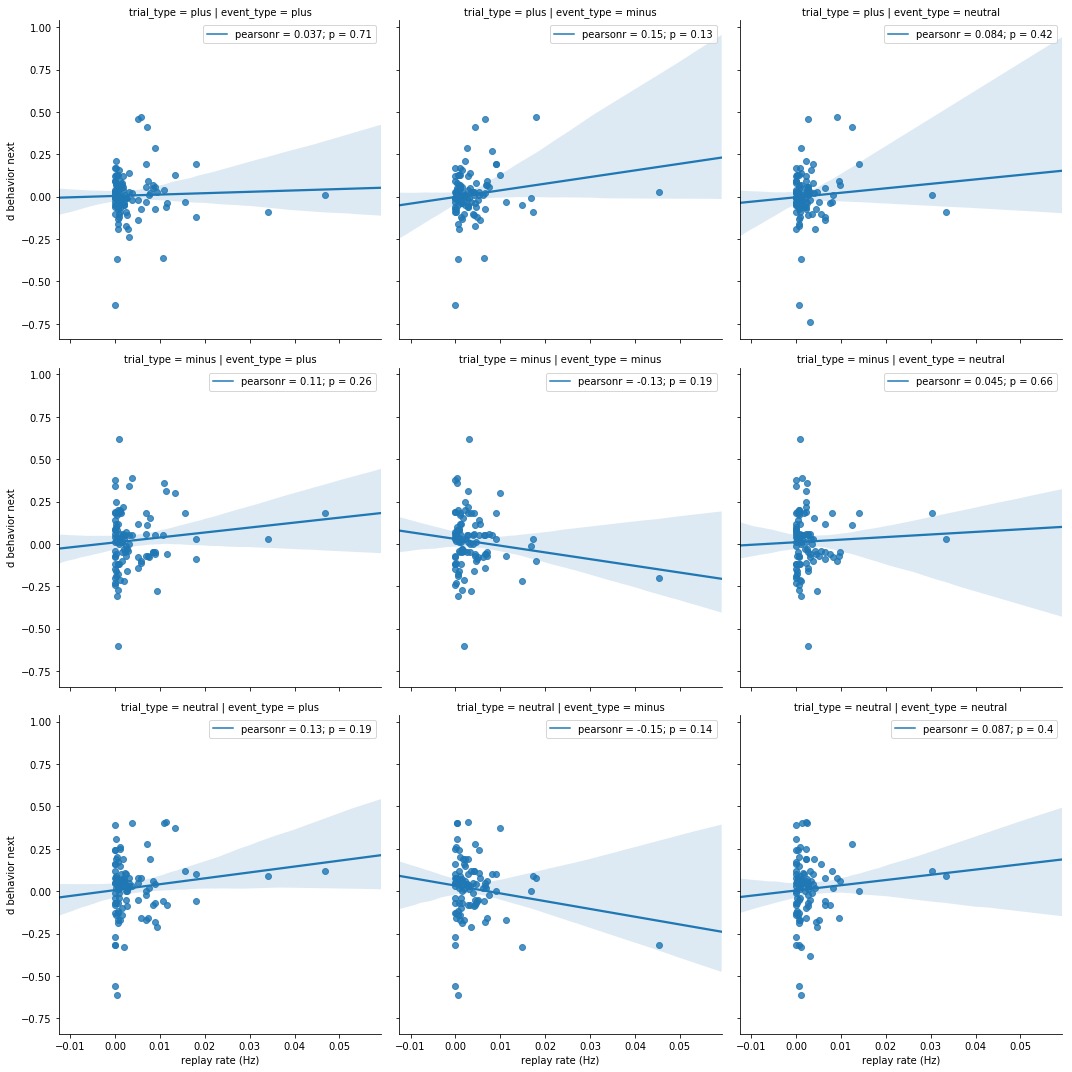

In [66]:
data_long = data[
    ['d_hmm_behav_plus_next', 'd_hmm_behav_minus_next', 'd_hmm_behav_neutral_next',
     'replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus']]
data_long = data_long.melt(
    value_vars=['d_hmm_behav_plus_next', 'd_hmm_behav_minus_next', 'd_hmm_behav_neutral_next'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
             'replay_freq_0_1_minus'],
    var_name='trial_type', value_name='behavior')
data_long.trial_type = data_long.trial_type.map(
    {'d_hmm_behav_plus_next': 'plus', 'd_hmm_behav_minus_next': 'minus',
     'd_hmm_behav_neutral_next': 'neutral'})
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['trial_type', 'behavior'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

data_long.dropna(subset=['events', 'behavior'], inplace=True)

g = sns.lmplot(
    x='events', y='behavior', col='event_type',
    row='trial_type', data=data_long, row_order=order, col_order=order)
g.set_ylabels('d behavior next')
g.set_xlabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

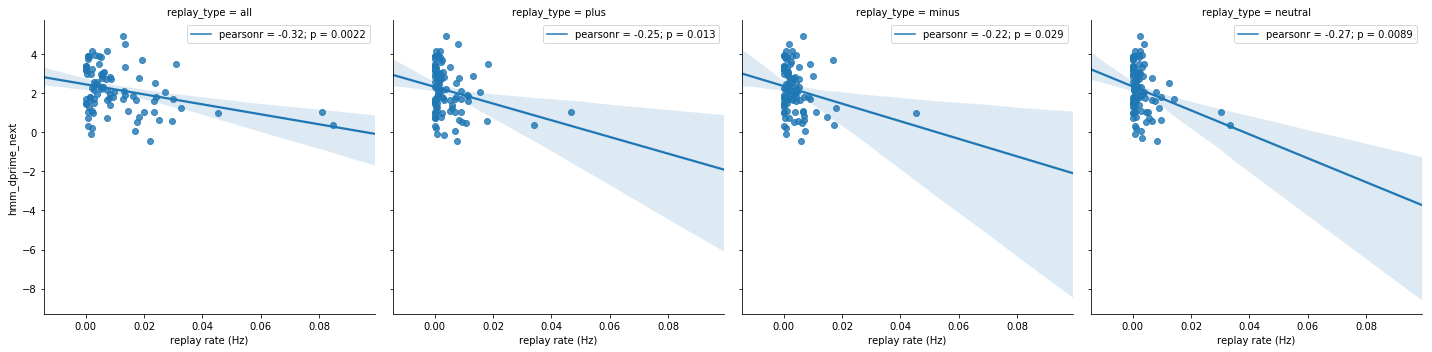

In [67]:
data_long = data[
    ['replay_freq_0_1_all', 'replay_freq_0_1_plus', 'replay_freq_0_1_minus',
     'replay_freq_0_1_neutral', 'hmm_dprime_next']]
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_all', 'replay_freq_0_1_plus',
                'replay_freq_0_1_minus', 'replay_freq_0_1_neutral'],
    id_vars=['hmm_dprime_next'],
    var_name='replay_type', value_name='replays')
data_long.replay_type = data_long.replay_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral', 'replay_freq_0_1_all': 'all'})
tmp_order = ['all', 'plus', 'minus', 'neutral']
g = sns.lmplot(
    x='replays', y='hmm_dprime_next', col='replay_type',
    data=data_long, col_order=tmp_order)
g.set_xlabels('replay rate (Hz)')

jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

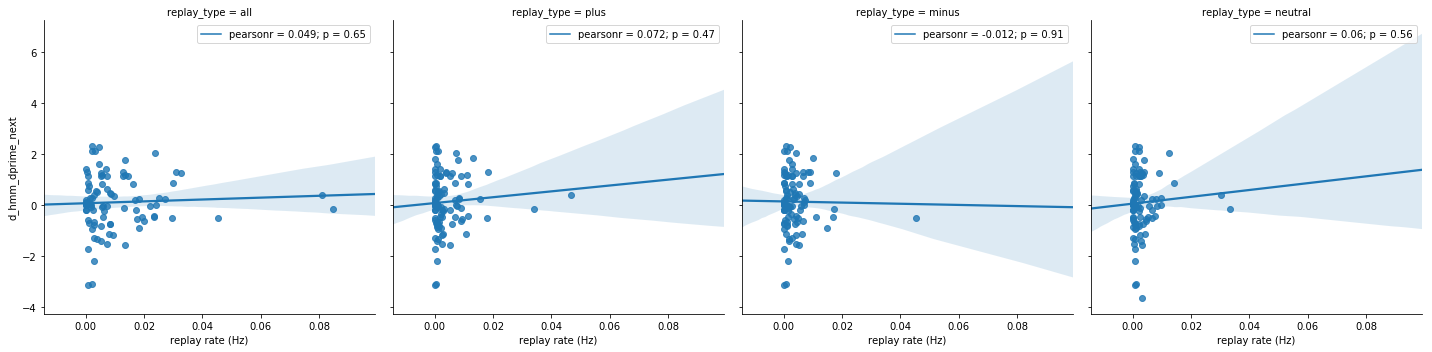

In [68]:
data_long = data[
    ['replay_freq_0_1_all', 'replay_freq_0_1_plus', 'replay_freq_0_1_minus',
     'replay_freq_0_1_neutral', 'd_hmm_dprime_next']]
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_all', 'replay_freq_0_1_plus',
                'replay_freq_0_1_minus', 'replay_freq_0_1_neutral'],
    id_vars=['d_hmm_dprime_next'],
    var_name='replay_type', value_name='replays')
data_long.replay_type = data_long.replay_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral', 'replay_freq_0_1_all': 'all'})
tmp_order = ['all', 'plus', 'minus', 'neutral']
g = sns.lmplot(
    x='replays', y='d_hmm_dprime_next', col='replay_type',
    data=data_long, col_order=tmp_order)
g.set_xlabels('replay rate (Hz)')

jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

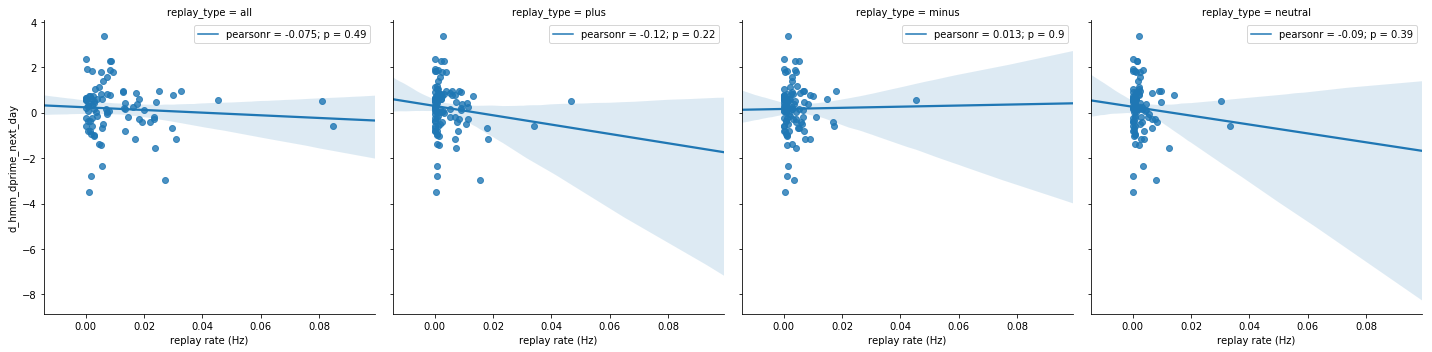

In [69]:
data_long = data[
    ['replay_freq_0_1_all', 'replay_freq_0_1_plus', 'replay_freq_0_1_minus',
     'replay_freq_0_1_neutral', 'd_hmm_dprime_next_day']]
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_all', 'replay_freq_0_1_plus',
                'replay_freq_0_1_minus', 'replay_freq_0_1_neutral'],
    id_vars=['d_hmm_dprime_next_day'],
    var_name='replay_type', value_name='replays')
data_long.replay_type = data_long.replay_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral', 'replay_freq_0_1_all': 'all'})
tmp_order = ['all', 'plus', 'minus', 'neutral']
g = sns.lmplot(
    x='replays', y='d_hmm_dprime_next_day', col='replay_type',
    data=data_long, col_order=tmp_order)
g.set_xlabels('replay rate (Hz)')

jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

In [70]:
formula = 'd_hmm_behav_minus_next ~ replay_freq_0_1_plus + replay_freq_0_1_minus + replay_freq_0_1_neutral'

data_sub = data[['replay_freq_0_1_plus', 'replay_freq_0_1_minus', 'replay_freq_0_1_neutral', 'd_hmm_behav_minus_next',
                 'mouse']]
data_sub.dropna(inplace=True)
# md = ols(formula, data_sub).fit()
# print(md.summary())

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)
family = sm.families.Gaussian()
glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

                    Results: Generalized linear model
Model:                GLM                     AIC:             -57.7366 
Link Function:        identity                BIC:             -384.4453
Dependent Variable:   d_hmm_behav_minus_next  Log-Likelihood:  32.868   
Date:                 2018-05-18 22:45        LL-Null:         30.608   
No. Observations:     90                      Deviance:        2.5384   
Df Model:             3                       Pearson chi2:    2.54     
Df Residuals:         86                      Scale:           0.029516 
Method:               IRLS                                              
------------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
------------------------------------------------------------------------
Intercept                0.0159   0.0228  0.6952 0.4869  -0.0289  0.0607
replay_freq_0_1_plus     5.4038   5.1792  1.0434 0.2968  -4.7473 15.55

# Fraction visually driven

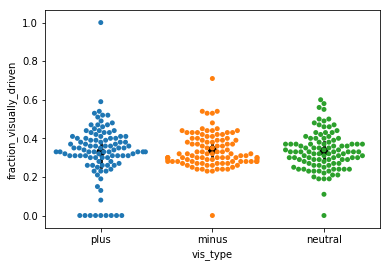

In [71]:
data_long = data[['fraction_visually_driven_50_plus', 'fraction_visually_driven_50_minus', 'fraction_visually_driven_50_neutral',
                  'replay_freq_0_1_plus', 'replay_freq_0_1_minus', 'replay_freq_0_1_neutral', 'mouse']]
data_long = data_long.melt(
    value_vars=['fraction_visually_driven_50_plus', 'fraction_visually_driven_50_minus', 'fraction_visually_driven_50_neutral'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus', 'replay_freq_0_1_neutral', 'mouse'],
    var_name='vis_type', value_name='fraction_visually_driven')
data_long.vis_type = data_long.vis_type.map(
    {'fraction_visually_driven_50_plus': 'plus', 'fraction_visually_driven_50_minus': 'minus',
     'fraction_visually_driven_50_neutral': 'neutral'})

sns.swarmplot(x='vis_type', y='fraction_visually_driven', data=data_long)
sns.pointplot(
    x='vis_type', y='fraction_visually_driven', data=data_long, units='mouse',
    color='k', join=False)

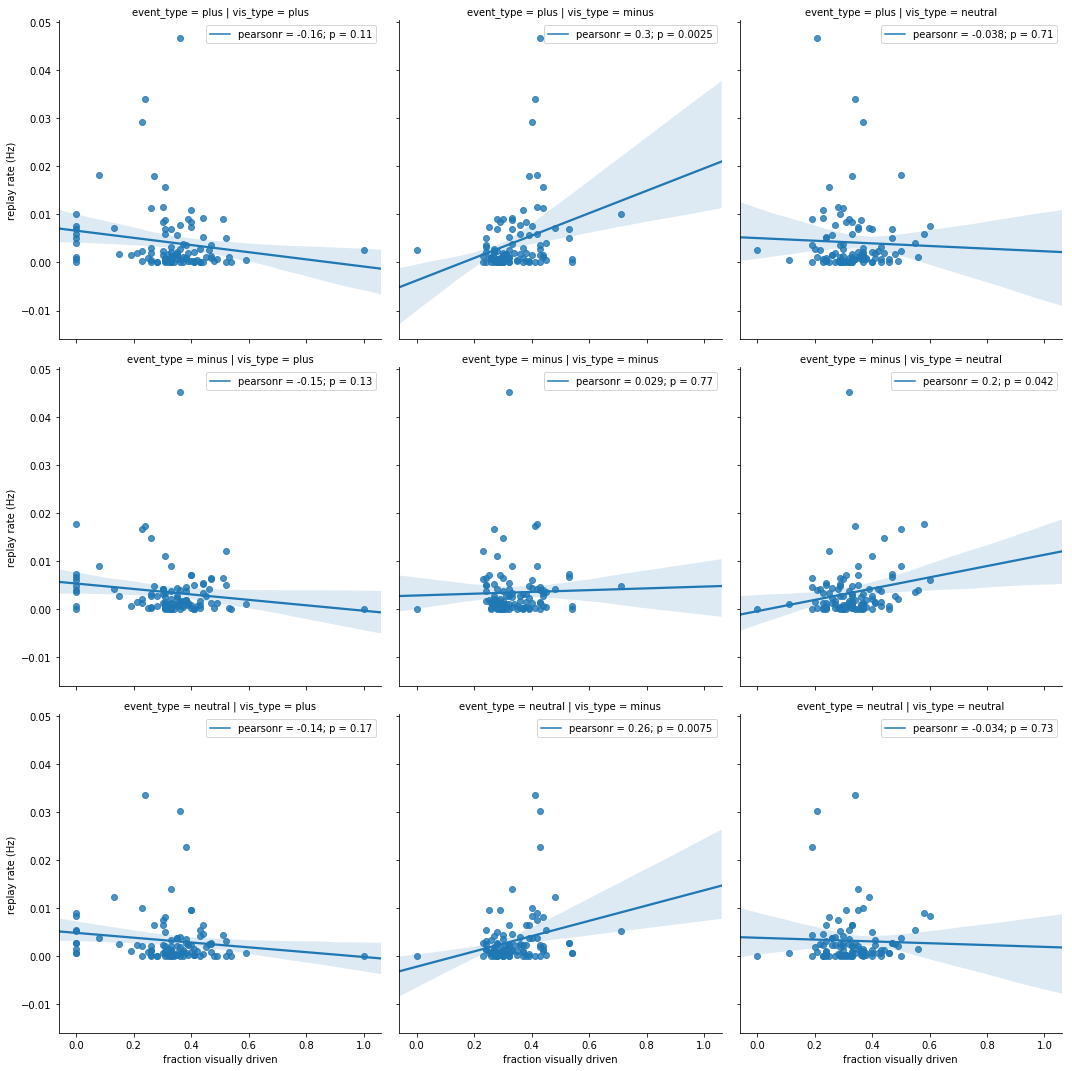

In [72]:
data_long = data[['fraction_visually_driven_50_plus', 'fraction_visually_driven_50_minus', 'fraction_visually_driven_50_neutral',
                  'replay_freq_0_1_plus', 'replay_freq_0_1_minus', 'replay_freq_0_1_neutral', 'mouse']]
data_long = data_long.melt(
    value_vars=['fraction_visually_driven_50_plus', 'fraction_visually_driven_50_minus', 'fraction_visually_driven_50_neutral'],
    id_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus', 'replay_freq_0_1_neutral', 'mouse'],
    var_name='vis_type', value_name='fraction_visually_driven')
data_long.vis_type = data_long.vis_type.map(
    {'fraction_visually_driven_50_plus': 'plus', 'fraction_visually_driven_50_minus': 'minus',
     'fraction_visually_driven_50_neutral': 'neutral'})
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus', 'replay_freq_0_1_neutral'],
    id_vars=['vis_type', 'fraction_visually_driven', 'mouse'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

g = sns.lmplot(
    x='fraction_visually_driven', y='events', col='vis_type', row='event_type',
    data=data_long)
g.set_xlabels('fraction visually driven')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

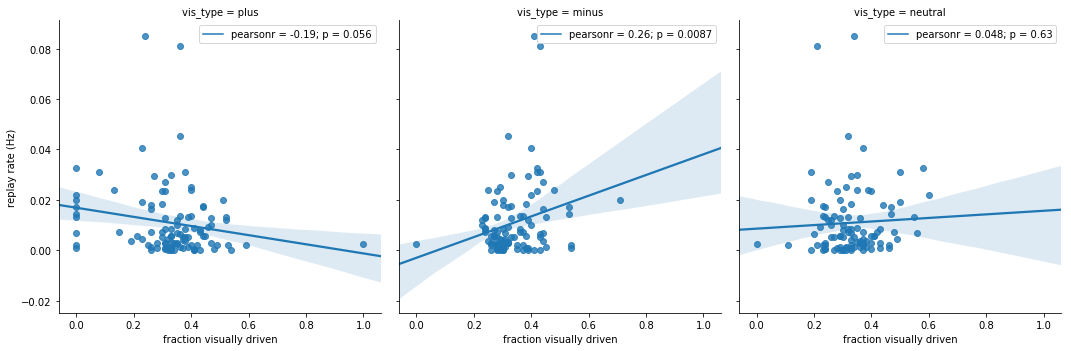

In [73]:
data_long = data[['fraction_visually_driven_50_plus', 'fraction_visually_driven_50_minus', 'fraction_visually_driven_50_neutral',
                  'replay_freq_0_1_all', 'mouse']]
data_long = data_long.melt(
    value_vars=['fraction_visually_driven_50_plus', 'fraction_visually_driven_50_minus', 'fraction_visually_driven_50_neutral'],
    id_vars=['replay_freq_0_1_all', 'mouse'],
    var_name='vis_type', value_name='fraction_visually_driven')
data_long.vis_type = data_long.vis_type.map(
    {'fraction_visually_driven_50_plus': 'plus', 'fraction_visually_driven_50_minus': 'minus',
     'fraction_visually_driven_50_neutral': 'neutral'})

g = sns.lmplot(
    x='fraction_visually_driven', y='replay_freq_0_1_all', col='vis_type',
    data=data_long)
g.set_xlabels('fraction visually driven')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

               Results: Generalized linear model
Model:              GLM                 AIC:            -inf  
Link Function:      log                 BIC:            3.6476
Dependent Variable: replay_freq_0_1_all Log-Likelihood: inf   
Date:               2018-05-20 17:24    LL-Null:        inf   
No. Observations:   103                 Deviance:       471.76
Df Model:           1                   Pearson chi2:   122.  
Df Residuals:       101                 Scale:          1.2041
Method:             IRLS                                      
--------------------------------------------------------------
               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------
Intercept     -3.9602   0.2082 -19.0204 0.0000 -4.3683 -3.5521
hmm_dprime    -0.3248   0.0882  -3.6813 0.0002 -0.4977 -0.1519



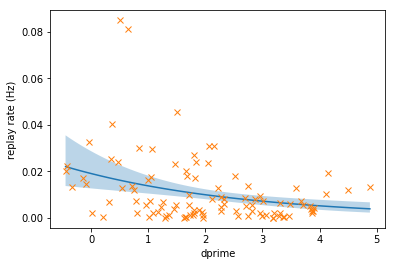

In [79]:
formula = 'replay_freq_0_1_all ~ hmm_dprime'

data_sub = data[['replay_freq_0_1_all', 'mouse', 'hmm_dprime']]
# data_sub['replay_freq_0_1_all'] *= 100
# 0s in the dependent variable still converges, but LL is infinite
# data_sub.replace(0, np.nan, inplace=True)
# data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)
# family = sm.families.Poisson(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

exog = glm.exog
x_val = np.linspace(exog[:, 1].min(), exog[:, 1].max(), exog.shape[0])
exog[:, 1] = x_val
predict = glm_results.get_prediction(exog)

fig, ax = plt.subplots()
ax.plot(x_val, predict.predicted_mean)
ax.fill_between(x_val, predict.conf_int()[:, 0], predict.conf_int()[:, 1], alpha=0.3)
ax.plot(data_sub.hmm_dprime, data_sub.replay_freq_0_1_all, 'x')
ax.set_xlabel('dprime')
ax.set_ylabel('replay rate (Hz)');

## Neutral replay predicted by plus/minus

In [75]:
formula = 'replay_freq_0_1_neutral ~ hmm_behavior_pm * hmm_behavior_neutral'

data_sub = data[['replay_freq_0_1_neutral', 'mouse',
                 'hmm_behavior_pm',
                 'hmm_behavior_neutral']]

# 0s in the dependent variable still converges, but LL is infinite
data_sub.replace(0, np.nan, inplace=True)
data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)


family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

exog = glm.exog
x1_range = (exog[:, 1:3].min(), exog[:, 1:3].max())
x2_range = x1_range
x1_val = np.linspace(x1_range[0], x1_range[1], exog.shape[0])
x2_val = np.linspace(x1_range[0], x1_range[1], exog.shape[0])
x1_val_mesh, x2_val_mesh = np.meshgrid(x1_val, x2_val)
new_exog = np.ones((np.prod(x1_val_mesh.shape), 4))
new_exog[:, 1] = x1_val_mesh.flat
new_exog[:, 2] = x2_val_mesh.flat
new_exog[:, 3] = np.multiply(x1_val_mesh.flat, x2_val_mesh.flat)
predict = glm_results.get_prediction(new_exog)

fig, ax = plt.subplots()
predict_react = np.reshape(predict.predicted_mean, x1_val_mesh.shape)
plt.imshow(np.flipud(predict_react),
          cmap=sns.cm.rocket_r, vmin=0, vmax=predict_react.max() * 0.05)
plt.colorbar()
ax.set_xticks([ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5])
ax.set_xticklabels(x1_range)
ax.set_yticks([ax.get_ylim()[0] + 0.5, ax.get_ylim()[1] - 0.5])
ax.set_yticklabels(x2_range)
ax.set_xlabel('# correct')
ax.set_ylabel('# false');

ValueError: zero-size array to reduction operation maximum which has no identity